In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.2
seed 1
2023-08-21 14:31:04.586323


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-5.7386)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-2.9783)
penalty_target_min tensor(-11.1772) penalty_target_max tensor(4.4211)
train_loss:  -7.606199763107298
valid_loss:  -7.467598365783692
h_min_tilde -11.177165 ell_tilde -7.578479483642577 kappa_tilde 0.0002635712610497018


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.660015821456909

 2 3.4974632263183594

 3 3.404994487762451

 4 3.396411657333374

 5 3.362656354904175

 6 3.508828639984131

 7 3.3938558101654053

 8 3.285923480987549

 9 3.357114553451538

 10 4.072192668914795

 11 6.855976581573486

 12 6.833709239959717

 13 6.345575571060181

 14 3.563553810119629

 15 3.5373215675354004

 16 3.4730067253112793

 17 3.417847156524658

 18 3.4906530380249023

 19 3.551055431365967

 20 3.4522764682769775

 21 3.3456075191497803

 22 4.947534799575806

 23 3.5268898010253906

 24 4.373098850250244

 25 7.041570425033569

 26 7.046658754348755

 27 3.3006694316864014

 28 3.8778858184814453

 29 3.927617311477661

 30 3.5047974586486816

 31 3.543994665145874

 32 3.5871334075927734

 33 3.518091917037964

 34 4.546295881271362

 35 4.025366544723511

 36 6.596136569976807

 37 6.146956443786621

 38 3.5646862983703613

 39 3.4912829399108887

 40 3.623755693435669

 41 3.4848792552948

 42 4.280197381973267

 43 4.175790071487427

 44 3.5

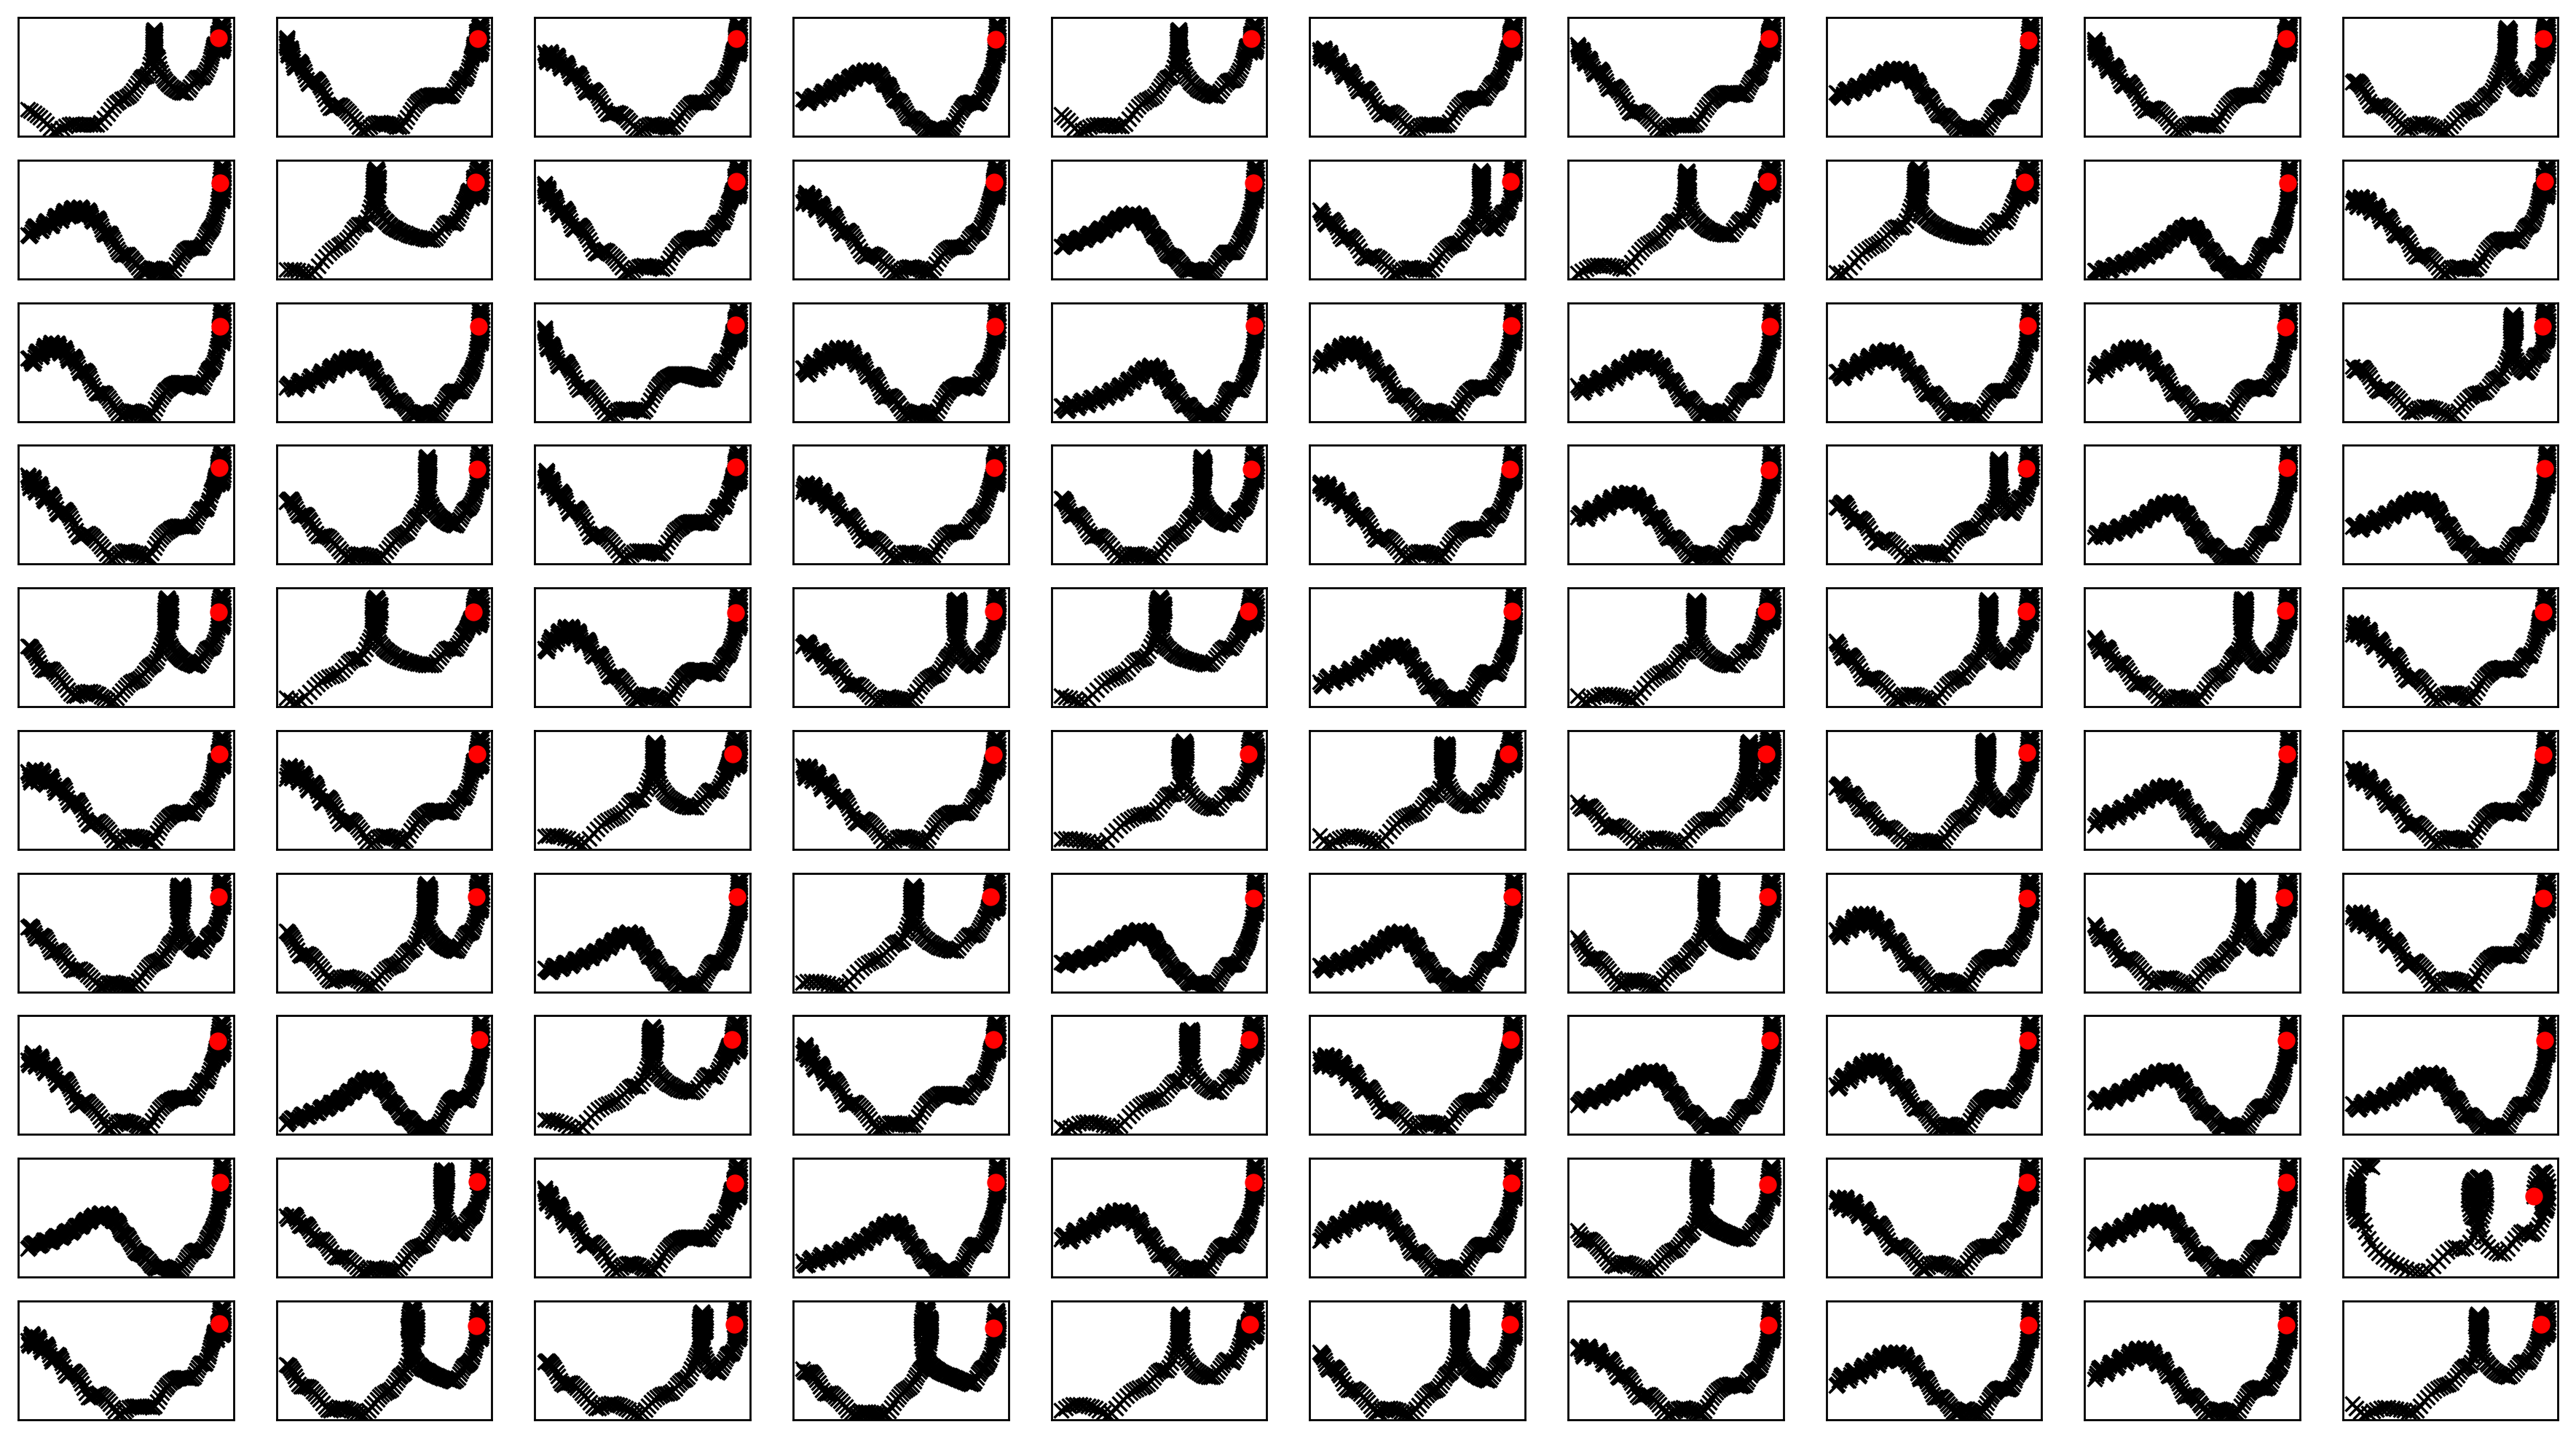

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

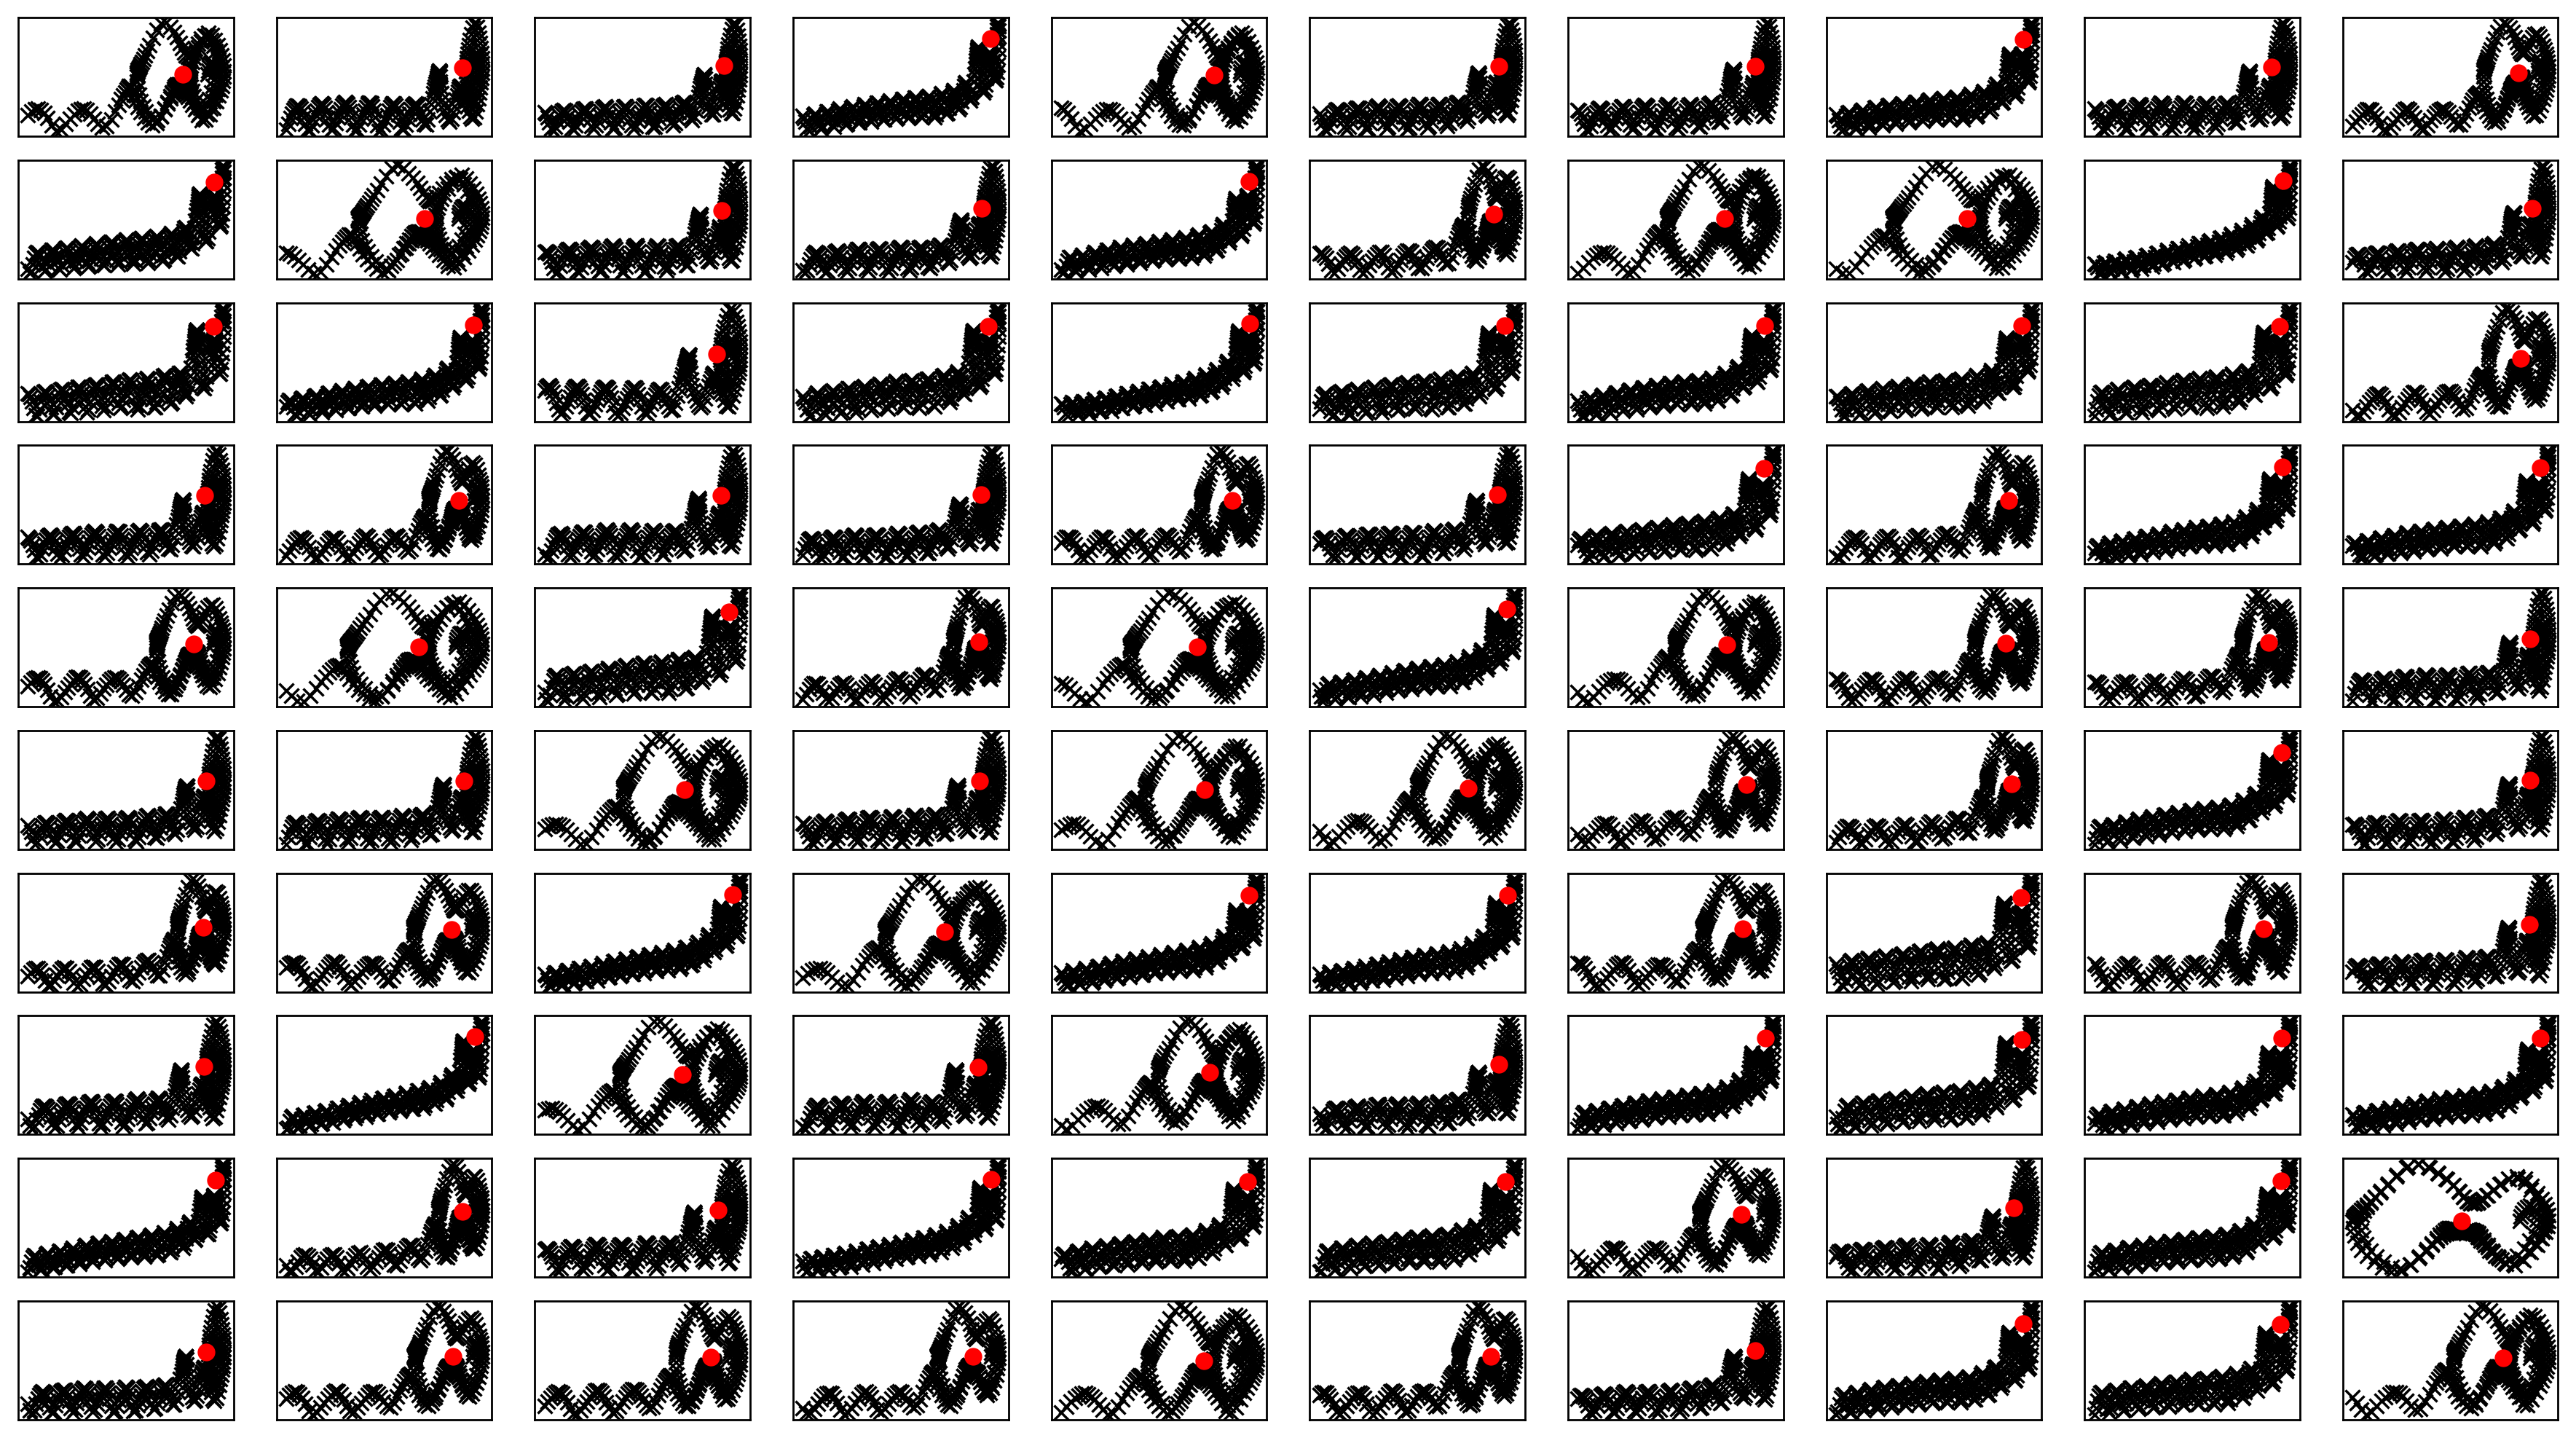

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
# plt.show()
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")

In [8]:
print(datetime.datetime.now())

2023-08-21 14:38:22.860651


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36376  validloss 1.42436±0.00000  bestvalidloss 1.42436  last_update 0
train: iter 1  trainloss 1.27621  validloss 1.32425±0.00000  bestvalidloss 1.32425  last_update 0
train: iter 2  trainloss 1.14857  validloss 1.23745±0.00000  bestvalidloss 1.23745  last_update 0
train: iter 3  trainloss 0.98586  validloss 1.08875±0.00000  bestvalidloss 1.08875  last_update 0
train: iter 4  trainloss 0.85736  validloss 0.94299±0.00000  bestvalidloss 0.94299  last_update 0
train: iter 5  trainloss 0.78900  validloss 0.85500±0.00000  bestvalidloss 0.85500  last_update 0
train: iter 6  trainloss 0.74757  validloss 0.81541±0.00000  bestvalidloss 0.81541  last_update 0
train: iter 7  trainloss 0.72171  validloss 0.78650±0.00000  bestvalidloss 0.78650  last_update 0
train: iter 8  trainloss 0.70212  validloss 0.76334±0.00000  bestvalidloss 0.76334  last_update 0
train: iter 9  trainloss 0.69248  validloss 0.75042±0.00000  bestvalidloss 0.75042  last_update 0
train: iter 10  trai

train: iter 84  trainloss 0.47326  validloss 0.56316±0.00000  bestvalidloss 0.55008  last_update 2
train: iter 85  trainloss 0.47080  validloss 0.56053±0.00000  bestvalidloss 0.55008  last_update 3
train: iter 86  trainloss 0.47056  validloss 0.57970±0.00000  bestvalidloss 0.55008  last_update 4
train: iter 87  trainloss 0.47303  validloss 0.55348±0.00000  bestvalidloss 0.55008  last_update 5
train: iter 88  trainloss 0.47599  validloss 0.55232±0.00000  bestvalidloss 0.55008  last_update 6
train: iter 89  trainloss 0.47133  validloss 0.55580±0.00000  bestvalidloss 0.55008  last_update 7
train: iter 90  trainloss 0.48196  validloss 0.54760±0.00000  bestvalidloss 0.54760  last_update 0
train: iter 91  trainloss 0.46901  validloss 0.55106±0.00000  bestvalidloss 0.54760  last_update 1
train: iter 92  trainloss 0.47540  validloss 0.55240±0.00000  bestvalidloss 0.54760  last_update 2
train: iter 93  trainloss 0.46702  validloss 0.54780±0.00000  bestvalidloss 0.54760  last_update 3
train: ite

train: iter 166  trainloss 0.43723  validloss 0.52189±0.00000  bestvalidloss 0.52189  last_update 0
train: iter 167  trainloss 0.43421  validloss 0.52651±0.00000  bestvalidloss 0.52189  last_update 1
train: iter 168  trainloss 0.43482  validloss 0.53369±0.00000  bestvalidloss 0.52189  last_update 2
train: iter 169  trainloss 0.43343  validloss 0.53517±0.00000  bestvalidloss 0.52189  last_update 3
train: iter 170  trainloss 0.43756  validloss 0.52961±0.00000  bestvalidloss 0.52189  last_update 4
train: iter 171  trainloss 0.43902  validloss 0.53318±0.00000  bestvalidloss 0.52189  last_update 5
train: iter 172  trainloss 0.43215  validloss 0.53418±0.00000  bestvalidloss 0.52189  last_update 6
train: iter 173  trainloss 0.43656  validloss 0.52757±0.00000  bestvalidloss 0.52189  last_update 7
train: iter 174  trainloss 0.43587  validloss 0.55692±0.00000  bestvalidloss 0.52189  last_update 8
train: iter 175  trainloss 0.43576  validloss 0.51762±0.00000  bestvalidloss 0.51762  last_update 0


train: iter 249  trainloss 0.41097  validloss 0.51160±0.00000  bestvalidloss 0.50520  last_update 6
train: iter 250  trainloss 0.40169  validloss 0.53172±0.00000  bestvalidloss 0.50520  last_update 7
train: iter 251  trainloss 0.41299  validloss 0.51135±0.00000  bestvalidloss 0.50520  last_update 8
train: iter 252  trainloss 0.39744  validloss 0.51642±0.00000  bestvalidloss 0.50520  last_update 9
train: iter 253  trainloss 0.39717  validloss 0.51463±0.00000  bestvalidloss 0.50520  last_update 10
train: iter 254  trainloss 0.39408  validloss 0.52770±0.00000  bestvalidloss 0.50520  last_update 11
train: iter 255  trainloss 0.39628  validloss 0.50546±0.00000  bestvalidloss 0.50520  last_update 12
train: iter 256  trainloss 0.39347  validloss 0.50177±0.00000  bestvalidloss 0.50177  last_update 0
train: iter 257  trainloss 0.39892  validloss 0.49584±0.00000  bestvalidloss 0.49584  last_update 0
train: iter 258  trainloss 0.39935  validloss 0.51719±0.00000  bestvalidloss 0.49584  last_update

train: iter 331  trainloss 0.37012  validloss 0.47416±0.00000  bestvalidloss 0.47416  last_update 0
train: iter 332  trainloss 0.36141  validloss 0.47654±0.00000  bestvalidloss 0.47416  last_update 1
train: iter 333  trainloss 0.36282  validloss 0.46471±0.00000  bestvalidloss 0.46471  last_update 0
train: iter 334  trainloss 0.36414  validloss 0.49570±0.00000  bestvalidloss 0.46471  last_update 1
train: iter 335  trainloss 0.37416  validloss 0.49648±0.00000  bestvalidloss 0.46471  last_update 2
train: iter 336  trainloss 0.36014  validloss 0.47077±0.00000  bestvalidloss 0.46471  last_update 3
train: iter 337  trainloss 0.36171  validloss 0.47867±0.00000  bestvalidloss 0.46471  last_update 4
train: iter 338  trainloss 0.36211  validloss 0.47979±0.00000  bestvalidloss 0.46471  last_update 5
train: iter 339  trainloss 0.35901  validloss 0.48220±0.00000  bestvalidloss 0.46471  last_update 6
train: iter 340  trainloss 0.36414  validloss 0.48172±0.00000  bestvalidloss 0.46471  last_update 7


train: iter 413  trainloss 0.33720  validloss 0.48261±0.00000  bestvalidloss 0.44889  last_update 5
train: iter 414  trainloss 0.33847  validloss 0.46743±0.00000  bestvalidloss 0.44889  last_update 6
train: iter 415  trainloss 0.33272  validloss 0.45200±0.00000  bestvalidloss 0.44889  last_update 7
train: iter 416  trainloss 0.33450  validloss 0.45437±0.00000  bestvalidloss 0.44889  last_update 8
train: iter 417  trainloss 0.33793  validloss 0.47139±0.00000  bestvalidloss 0.44889  last_update 9
train: iter 418  trainloss 0.33491  validloss 0.49395±0.00000  bestvalidloss 0.44889  last_update 10
train: iter 419  trainloss 0.33680  validloss 0.45503±0.00000  bestvalidloss 0.44889  last_update 11
train: iter 420  trainloss 0.33642  validloss 0.44867±0.00000  bestvalidloss 0.44867  last_update 0
train: iter 421  trainloss 0.33588  validloss 0.44375±0.00000  bestvalidloss 0.44375  last_update 0
train: iter 422  trainloss 0.33794  validloss 0.46453±0.00000  bestvalidloss 0.44375  last_update 

train: iter 495  trainloss 0.32017  validloss 0.45812±0.00000  bestvalidloss 0.43931  last_update 8
train: iter 496  trainloss 0.32829  validloss 0.44611±0.00000  bestvalidloss 0.43931  last_update 9
train: iter 497  trainloss 0.31735  validloss 0.45700±0.00000  bestvalidloss 0.43931  last_update 10
train: iter 498  trainloss 0.31577  validloss 0.44440±0.00000  bestvalidloss 0.43931  last_update 11
train: iter 499  trainloss 0.31516  validloss 0.46322±0.00000  bestvalidloss 0.43931  last_update 12
train: iter 500  trainloss 0.31697  validloss 0.43938±0.00000  bestvalidloss 0.43931  last_update 13
train: iter 501  trainloss 0.31647  validloss 0.44117±0.00000  bestvalidloss 0.43931  last_update 14
train: iter 502  trainloss 0.32068  validloss 0.43946±0.00000  bestvalidloss 0.43931  last_update 15
train: iter 503  trainloss 0.31370  validloss 0.47149±0.00000  bestvalidloss 0.43931  last_update 16
train: iter 504  trainloss 0.31847  validloss 0.45341±0.00000  bestvalidloss 0.43931  last_up

train: iter 577  trainloss 0.30938  validloss 0.43741±0.00000  bestvalidloss 0.43187  last_update 34
train: iter 578  trainloss 0.30323  validloss 0.45822±0.00000  bestvalidloss 0.43187  last_update 35
train: iter 579  trainloss 0.30544  validloss 0.48068±0.00000  bestvalidloss 0.43187  last_update 36
train: iter 580  trainloss 0.30047  validloss 0.46546±0.00000  bestvalidloss 0.43187  last_update 37
train: iter 581  trainloss 0.30673  validloss 0.44862±0.00000  bestvalidloss 0.43187  last_update 38
train: iter 582  trainloss 0.30246  validloss 0.45294±0.00000  bestvalidloss 0.43187  last_update 39
train: iter 583  trainloss 0.30951  validloss 0.45393±0.00000  bestvalidloss 0.43187  last_update 40
train: iter 584  trainloss 0.30289  validloss 0.44984±0.00000  bestvalidloss 0.43187  last_update 41
train: iter 585  trainloss 0.30159  validloss 0.44597±0.00000  bestvalidloss 0.43187  last_update 42
train: iter 586  trainloss 0.30776  validloss 0.44686±0.00000  bestvalidloss 0.43187  last_

train: iter 659  trainloss 0.29494  validloss 0.44440±0.00000  bestvalidloss 0.43092  last_update 15
train: iter 660  trainloss 0.29118  validloss 0.44646±0.00000  bestvalidloss 0.43092  last_update 16
train: iter 661  trainloss 0.29922  validloss 0.44378±0.00000  bestvalidloss 0.43092  last_update 17
train: iter 662  trainloss 0.29152  validloss 0.45007±0.00000  bestvalidloss 0.43092  last_update 18
train: iter 663  trainloss 0.29129  validloss 0.44920±0.00000  bestvalidloss 0.43092  last_update 19
train: iter 664  trainloss 0.30539  validloss 0.47085±0.00000  bestvalidloss 0.43092  last_update 20
train: iter 665  trainloss 0.29205  validloss 0.45429±0.00000  bestvalidloss 0.43092  last_update 21
train: iter 666  trainloss 0.30176  validloss 0.46729±0.00000  bestvalidloss 0.43092  last_update 22
train: iter 667  trainloss 0.29472  validloss 0.44107±0.00000  bestvalidloss 0.43092  last_update 23
train: iter 668  trainloss 0.30159  validloss 0.46025±0.00000  bestvalidloss 0.43092  last_

train: iter 742  trainloss 0.29044  validloss 0.45062±0.00000  bestvalidloss 0.43092  last_update 98
train: iter 743  trainloss 0.28114  validloss 0.45338±0.00000  bestvalidloss 0.43092  last_update 99
train: iter 744  trainloss 0.28882  validloss 0.48733±0.00000  bestvalidloss 0.43092  last_update 100
train: fin


train_loss:  -3.934106799638272
valid_loss:  -8.234030503559111
weight_alpha 1.0 h_min_tilde -11.177165 ell_tilde -4.79409154042244 kappa_tilde 0.00019790423232143747
train_loss:  -2.2855857772588726
valid_loss:  -2.8677266002655033
weight_alpha 0.2 h_min_tilde -11.177165 ell_tilde -2.402013941860199 kappa_tilde 0.00016878844140489905


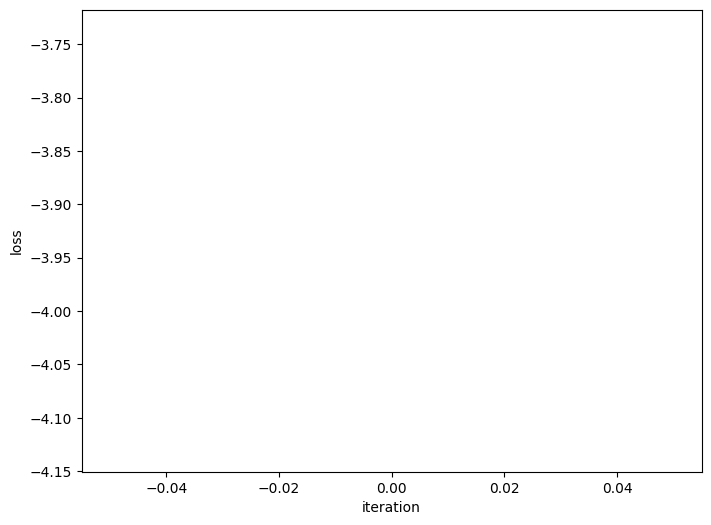

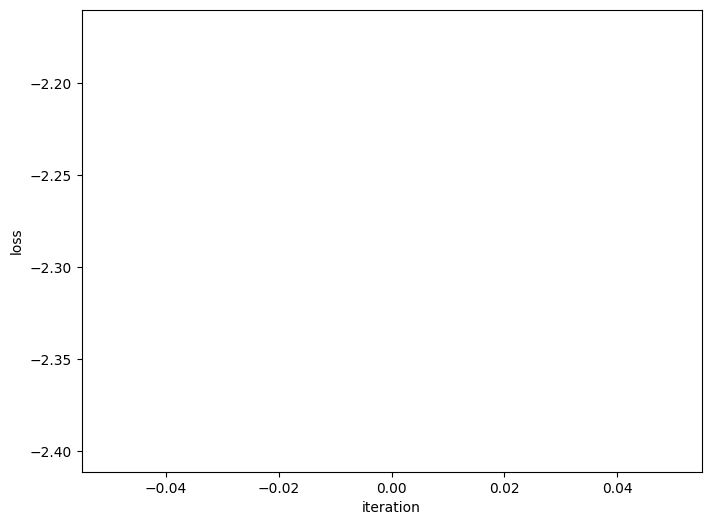

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -442.11323  validloss -568.08444±0.00000  bestvalidloss -568.08444  last_update 0
train: iter 1  trainloss -440.10846  validloss -554.75362±0.00000  bestvalidloss -568.08444  last_update 1
train: iter 2  trainloss -443.12156  validloss -559.33915±0.00000  bestvalidloss -568.08444  last_update 2
train: iter 3  trainloss -450.87861  validloss -572.42778±0.00000  bestvalidloss -572.42778  last_update 0
train: iter 4  trainloss -449.62861  validloss -556.11270±0.00000  bestvalidloss -572.42778  last_update 1
train: iter 5  trainloss -451.70118  validloss -562.98183±0.00000  bestvalidloss -572.42778  last_update 2
train: iter 6  trainloss -438.68698  validloss -578.52484±0.00000  bestvalidloss -578.52484  last_update 0
train: iter 7  trainloss -449.31387  validloss -564.05768±0.00000  bestvalidloss -578.52484  last_update 1
train: iter 8  trainloss -452.25652  validloss -566.73378±0.00000  bestvalidloss -578.52484  last_u

train: iter 76  trainloss -483.26617  validloss -581.80397±0.00000  bestvalidloss -603.82261  last_update 19
train: iter 77  trainloss -471.23993  validloss -549.23944±0.00000  bestvalidloss -603.82261  last_update 20
train: iter 78  trainloss -470.57211  validloss -566.22716±0.00000  bestvalidloss -603.82261  last_update 21
train: iter 79  trainloss -469.01400  validloss -580.78229±0.00000  bestvalidloss -603.82261  last_update 22
train: iter 80  trainloss -447.78361  validloss -519.63881±0.00000  bestvalidloss -603.82261  last_update 23
train: iter 81  trainloss -467.06254  validloss -569.25489±0.00000  bestvalidloss -603.82261  last_update 24
train: iter 82  trainloss -476.80888  validloss -599.32302±0.00000  bestvalidloss -603.82261  last_update 25
train: iter 83  trainloss -477.98004  validloss -578.73475±0.00000  bestvalidloss -603.82261  last_update 26
train: iter 84  trainloss -471.37957  validloss -574.06182±0.00000  bestvalidloss -603.82261  last_update 27
train: iter 85  tra

train: iter 152  trainloss -518.45410  validloss -621.46143±0.00000  bestvalidloss -627.79161  last_update 3
train: iter 153  trainloss -473.75739  validloss -633.13714±0.00000  bestvalidloss -633.13714  last_update 0
train: iter 154  trainloss -516.68450  validloss -440.71383±0.00000  bestvalidloss -633.13714  last_update 1
train: iter 155  trainloss -517.01296  validloss -616.07899±0.00000  bestvalidloss -633.13714  last_update 2
train: iter 156  trainloss -517.66416  validloss -627.08642±0.00000  bestvalidloss -633.13714  last_update 3
train: iter 157  trainloss -520.90993  validloss -621.41520±0.00000  bestvalidloss -633.13714  last_update 4
train: iter 158  trainloss -520.99021  validloss -634.37587±0.00000  bestvalidloss -634.37587  last_update 0
train: iter 159  trainloss -522.77339  validloss -586.38948±0.00000  bestvalidloss -634.37587  last_update 1
train: iter 160  trainloss -516.24783  validloss -627.13199±0.00000  bestvalidloss -634.37587  last_update 2
train: iter 161  tr

train: iter 228  trainloss -573.25249  validloss -653.57441±0.00000  bestvalidloss -687.40237  last_update 24
train: iter 229  trainloss -599.19135  validloss -674.86449±0.00000  bestvalidloss -687.40237  last_update 25
train: iter 230  trainloss -577.67407  validloss -683.14352±0.00000  bestvalidloss -687.40237  last_update 26
train: iter 231  trainloss -582.37914  validloss -643.96874±0.00000  bestvalidloss -687.40237  last_update 27
train: iter 232  trainloss -592.42600  validloss -671.56127±0.00000  bestvalidloss -687.40237  last_update 28
train: iter 233  trainloss -576.52613  validloss -671.01562±0.00000  bestvalidloss -687.40237  last_update 29
train: iter 234  trainloss -597.33705  validloss -670.23755±0.00000  bestvalidloss -687.40237  last_update 30
train: iter 235  trainloss -601.52027  validloss -634.33347±0.00000  bestvalidloss -687.40237  last_update 31
train: iter 236  trainloss -597.92724  validloss -621.65948±0.00000  bestvalidloss -687.40237  last_update 32
train: ite

train: iter 303  trainloss -625.58510  validloss -675.24150±0.00000  bestvalidloss -758.41240  last_update 9
train: iter 304  trainloss -650.51595  validloss -677.74730±0.00000  bestvalidloss -758.41240  last_update 10
train: iter 305  trainloss -648.79641  validloss -683.94131±0.00000  bestvalidloss -758.41240  last_update 11
train: iter 306  trainloss -654.45720  validloss -722.24580±0.00000  bestvalidloss -758.41240  last_update 12
train: iter 307  trainloss -647.30310  validloss -683.96982±0.00000  bestvalidloss -758.41240  last_update 13
train: iter 308  trainloss -645.91603  validloss -700.55668±0.00000  bestvalidloss -758.41240  last_update 14
train: iter 309  trainloss -648.18384  validloss -729.55909±0.00000  bestvalidloss -758.41240  last_update 15
train: iter 310  trainloss -635.24005  validloss -737.75785±0.00000  bestvalidloss -758.41240  last_update 16
train: iter 311  trainloss -606.75722  validloss -702.01110±0.00000  bestvalidloss -758.41240  last_update 17
train: iter

train: iter 378  trainloss -692.59953  validloss -726.72970±0.00000  bestvalidloss -786.32691  last_update 47
train: iter 379  trainloss -689.26853  validloss -736.68761±0.00000  bestvalidloss -786.32691  last_update 48
train: iter 380  trainloss -680.84523  validloss -766.17558±0.00000  bestvalidloss -786.32691  last_update 49
train: iter 381  trainloss -687.43267  validloss -667.90964±0.00000  bestvalidloss -786.32691  last_update 50
train: iter 382  trainloss -687.66120  validloss -725.24724±0.00000  bestvalidloss -786.32691  last_update 51
train: iter 383  trainloss -700.00890  validloss -745.10917±0.00000  bestvalidloss -786.32691  last_update 52
train: iter 384  trainloss -700.23925  validloss -718.64743±0.00000  bestvalidloss -786.32691  last_update 53
train: iter 385  trainloss -689.34229  validloss -716.28716±0.00000  bestvalidloss -786.32691  last_update 54
train: iter 386  trainloss -694.75656  validloss -736.62180±0.00000  bestvalidloss -786.32691  last_update 55
train: ite

train: iter 453  trainloss -726.03755  validloss -768.68230±0.00000  bestvalidloss -795.98989  last_update 23
train: iter 454  trainloss -733.43394  validloss -710.26234±0.00000  bestvalidloss -795.98989  last_update 24
train: iter 455  trainloss -719.00247  validloss -767.05607±0.00000  bestvalidloss -795.98989  last_update 25
train: iter 456  trainloss -742.92129  validloss -743.71575±0.00000  bestvalidloss -795.98989  last_update 26
train: iter 457  trainloss -722.45247  validloss -743.79643±0.00000  bestvalidloss -795.98989  last_update 27
train: iter 458  trainloss -744.18858  validloss -782.32270±0.00000  bestvalidloss -795.98989  last_update 28
train: iter 459  trainloss -725.58478  validloss -745.34168±0.00000  bestvalidloss -795.98989  last_update 29
train: iter 460  trainloss -729.89939  validloss -746.29366±0.00000  bestvalidloss -795.98989  last_update 30
train: iter 461  trainloss -738.51669  validloss -778.01216±0.00000  bestvalidloss -795.98989  last_update 31
train: ite

train: iter 528  trainloss -763.45489  validloss -714.75477±0.00000  bestvalidloss -799.72601  last_update 22
train: iter 529  trainloss -734.71429  validloss -770.32297±0.00000  bestvalidloss -799.72601  last_update 23
train: iter 530  trainloss -734.47818  validloss -637.23313±0.00000  bestvalidloss -799.72601  last_update 24
train: iter 531  trainloss -763.10377  validloss -798.52850±0.00000  bestvalidloss -799.72601  last_update 25
train: iter 532  trainloss -752.46183  validloss -737.26134±0.00000  bestvalidloss -799.72601  last_update 26
train: iter 533  trainloss -771.29867  validloss -785.66391±0.00000  bestvalidloss -799.72601  last_update 27
train: iter 534  trainloss -751.30119  validloss -761.42504±0.00000  bestvalidloss -799.72601  last_update 28
train: iter 535  trainloss -741.58013  validloss -788.02805±0.00000  bestvalidloss -799.72601  last_update 29
train: iter 536  trainloss -762.08553  validloss -727.59153±0.00000  bestvalidloss -799.72601  last_update 30
train: ite

train: iter 603  trainloss -732.75482  validloss -660.65943±0.00000  bestvalidloss -825.11801  last_update 7
train: iter 604  trainloss -790.36043  validloss -812.85408±0.00000  bestvalidloss -825.11801  last_update 8
train: iter 605  trainloss -778.00653  validloss -796.37367±0.00000  bestvalidloss -825.11801  last_update 9
train: iter 606  trainloss -793.53127  validloss -794.92924±0.00000  bestvalidloss -825.11801  last_update 10
train: iter 607  trainloss -783.02522  validloss -778.29218±0.00000  bestvalidloss -825.11801  last_update 11
train: iter 608  trainloss -784.67900  validloss -780.67402±0.00000  bestvalidloss -825.11801  last_update 12
train: iter 609  trainloss -791.45280  validloss -803.63169±0.00000  bestvalidloss -825.11801  last_update 13
train: iter 610  trainloss -800.46564  validloss -816.92197±0.00000  bestvalidloss -825.11801  last_update 14
train: iter 611  trainloss -801.23814  validloss -826.28148±0.00000  bestvalidloss -826.28148  last_update 0
train: iter 61

train: iter 678  trainloss -791.65542  validloss -791.73431±0.00000  bestvalidloss -832.71987  last_update 3
train: iter 679  trainloss -801.16672  validloss -791.26932±0.00000  bestvalidloss -832.71987  last_update 4
train: iter 680  trainloss -814.63206  validloss -787.14567±0.00000  bestvalidloss -832.71987  last_update 5
train: iter 681  trainloss -813.28372  validloss -756.51843±0.00000  bestvalidloss -832.71987  last_update 6
train: iter 682  trainloss -824.07332  validloss -812.30007±0.00000  bestvalidloss -832.71987  last_update 7
train: iter 683  trainloss -806.14668  validloss -763.04014±0.00000  bestvalidloss -832.71987  last_update 8
train: iter 684  trainloss -791.28529  validloss -778.68042±0.00000  bestvalidloss -832.71987  last_update 9
train: iter 685  trainloss -777.06737  validloss -702.50296±0.00000  bestvalidloss -832.71987  last_update 10
train: iter 686  trainloss -823.91221  validloss -806.32893±0.00000  bestvalidloss -832.71987  last_update 11
train: iter 687  

train: iter 753  trainloss -820.22801  validloss -813.81251±0.00000  bestvalidloss -844.58429  last_update 22
train: iter 754  trainloss -834.51782  validloss -822.71671±0.00000  bestvalidloss -844.58429  last_update 23
train: iter 755  trainloss -803.13319  validloss -711.21461±0.00000  bestvalidloss -844.58429  last_update 24
train: iter 756  trainloss -837.61053  validloss -820.65208±0.00000  bestvalidloss -844.58429  last_update 25
train: iter 757  trainloss -824.34507  validloss -786.68792±0.00000  bestvalidloss -844.58429  last_update 26
train: iter 758  trainloss -834.39600  validloss -841.72591±0.00000  bestvalidloss -844.58429  last_update 27
train: iter 759  trainloss -833.23165  validloss -826.80841±0.00000  bestvalidloss -844.58429  last_update 28
train: iter 760  trainloss -837.70709  validloss -803.97009±0.00000  bestvalidloss -844.58429  last_update 29
train: iter 761  trainloss -845.50300  validloss -823.61889±0.00000  bestvalidloss -844.58429  last_update 30
train: ite

train: iter 828  trainloss -864.88545  validloss -796.33970±0.00000  bestvalidloss -854.39167  last_update 20
train: iter 829  trainloss -854.37460  validloss -792.85565±0.00000  bestvalidloss -854.39167  last_update 21
train: iter 830  trainloss -865.98567  validloss -806.60565±0.00000  bestvalidloss -854.39167  last_update 22
train: iter 831  trainloss -858.69351  validloss -823.29765±0.00000  bestvalidloss -854.39167  last_update 23
train: iter 832  trainloss -872.69289  validloss -837.78722±0.00000  bestvalidloss -854.39167  last_update 24
train: iter 833  trainloss -807.15916  validloss -822.79408±0.00000  bestvalidloss -854.39167  last_update 25
train: iter 834  trainloss -840.88552  validloss -826.85759±0.00000  bestvalidloss -854.39167  last_update 26
train: iter 835  trainloss -849.54471  validloss -805.42763±0.00000  bestvalidloss -854.39167  last_update 27
train: iter 836  trainloss -862.91420  validloss -804.01348±0.00000  bestvalidloss -854.39167  last_update 28
train: ite

train: iter 903  trainloss -876.57052  validloss -863.08491±0.00000  bestvalidloss -879.67302  last_update 36
train: iter 904  trainloss -886.82022  validloss -836.82766±0.00000  bestvalidloss -879.67302  last_update 37
train: iter 905  trainloss -877.93533  validloss -834.14532±0.00000  bestvalidloss -879.67302  last_update 38
train: iter 906  trainloss -881.69002  validloss -805.72964±0.00000  bestvalidloss -879.67302  last_update 39
train: iter 907  trainloss -878.23792  validloss -840.74388±0.00000  bestvalidloss -879.67302  last_update 40
train: iter 908  trainloss -890.70609  validloss -865.85586±0.00000  bestvalidloss -879.67302  last_update 41
train: iter 909  trainloss -871.39518  validloss -790.40348±0.00000  bestvalidloss -879.67302  last_update 42
train: iter 910  trainloss -867.33226  validloss -810.00063±0.00000  bestvalidloss -879.67302  last_update 43
train: iter 911  trainloss -883.25687  validloss -830.26864±0.00000  bestvalidloss -879.67302  last_update 44
train: ite

train: iter 978  trainloss -873.17891  validloss -835.43863±0.00000  bestvalidloss -906.11450  last_update 13
train: iter 979  trainloss -831.34572  validloss -832.27867±0.00000  bestvalidloss -906.11450  last_update 14
train: iter 980  trainloss -848.08185  validloss -793.63706±0.00000  bestvalidloss -906.11450  last_update 15
train: iter 981  trainloss -881.99620  validloss -879.56873±0.00000  bestvalidloss -906.11450  last_update 16
train: iter 982  trainloss -880.38662  validloss -840.61393±0.00000  bestvalidloss -906.11450  last_update 17
train: iter 983  trainloss -890.16618  validloss -865.06453±0.00000  bestvalidloss -906.11450  last_update 18
train: iter 984  trainloss -884.62738  validloss -863.14163±0.00000  bestvalidloss -906.11450  last_update 19
train: iter 985  trainloss -884.29372  validloss -835.65170±0.00000  bestvalidloss -906.11450  last_update 20
train: iter 986  trainloss -889.49679  validloss -840.34618±0.00000  bestvalidloss -906.11450  last_update 21
train: ite

train: iter 1053  trainloss -820.91012  validloss -847.89932±0.00000  bestvalidloss -906.11450  last_update 88
train: iter 1054  trainloss -869.34730  validloss -727.42722±0.00000  bestvalidloss -906.11450  last_update 89
train: iter 1055  trainloss -879.05831  validloss -864.76644±0.00000  bestvalidloss -906.11450  last_update 90
train: iter 1056  trainloss -832.70046  validloss -877.21604±0.00000  bestvalidloss -906.11450  last_update 91
train: iter 1057  trainloss -865.74246  validloss -880.19042±0.00000  bestvalidloss -906.11450  last_update 92
train: iter 1058  trainloss -868.60877  validloss -854.86479±0.00000  bestvalidloss -906.11450  last_update 93
train: iter 1059  trainloss -814.29938  validloss -824.05379±0.00000  bestvalidloss -906.11450  last_update 94
train: iter 1060  trainloss -837.19052  validloss -654.11550±0.00000  bestvalidloss -906.11450  last_update 95
train: iter 1061  trainloss -872.36408  validloss -847.91134±0.00000  bestvalidloss -906.11450  last_update 96
t

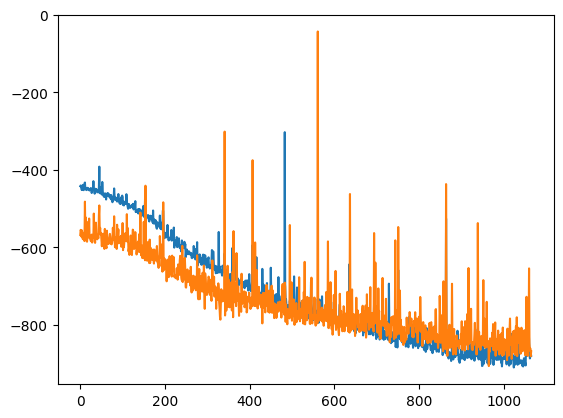

alpha 0.2 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-08-21 15:10:49.205328


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [-22.99270702 -21.13648377 -44.36304826 -28.8729563 ] [-1.09541799 -0.84273853 -1.64846538 -1.08822616] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 60

 1
predict diverge [-23.18173319 -21.16925851 -26.70633741 -20.62213336] [-1.13105976 -0.71092007 -1.14438653 -1.66857309] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 106
predict diverge [-24.6719033   -6.27881937 -13.13034198  45.74639885] [-0.28948497 -0.33458709  0.70961436 28.73322076] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 100
predict diverge [-22.01592391  14.04258578 -10.37868839 112.40159826] [-0.76346427 29.73528984  1.44440164 82.5936347 ] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 112
predict diverge [-14.3613433   22.62837291 -10.28307415 -89.68698279] [  -0.1

predict diverge [-28.05639901  -5.77632931 -22.61666836  49.51901531] [-0.35815092  1.87256578  0.70906923 34.8615617 ] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 107

 16
predict diverge [-23.92188879 -21.21067102 -31.57786188 -21.03432112] [-1.11474208 -0.7737104  -1.37004584  0.79291954] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 84

 17
predict diverge [-18.86712737  -5.7699577   -9.91373724  61.55131821] [-0.20444486 -1.00729983  0.98964962 39.30810528] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 76
predict diverge [-19.67765793  -7.77996696  -9.51615888 -38.50544251] [ -0.37837528  -0.31004229   0.89195834 -56.80483722] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 55
predict diverge [-29.82201845 -31.95705111 -18.45016248 593.3199849 ] [-2

predict diverge [ -19.43319753  -31.78182296  -10.41369895 -174.83541115] [  -0.56475536  -21.14916856    1.65000317 -209.43382633] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 123

 32
predict diverge [-17.13620473 -20.89691767 -26.79566173 -22.64314743] [-1.11404767 -0.89826629 -1.25344148 -2.77768447] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 81

 33
predict diverge [-30.43023578   9.56226445 -16.94803147  50.5827603 ] [-0.19007814 10.79418224  1.29581563 21.96663731] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 146
predict diverge [-24.20558292 -21.57776457 -39.00354893 -23.94645376] [-1.15191227 -0.95200874 -1.47099361 -1.00519194] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 133

 34
predict diverge [-11.96448748 -10.78342078 -18.64099558 -5


 47
predict diverge [-13.59120838  -5.52143462 -12.26879986  52.34997877] [-2.60265927e-01 -1.78303048e-02  7.89684558e-01  3.56588933e+01] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 83
predict diverge [-28.86302534 -27.57840065  -5.535688   174.25220514] [ -0.13853752 -27.89011807   1.61839404 138.29412494] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 118
predict diverge [-51.76858203  -9.03587175 -53.16711262  55.35407683] [-1.11768092  2.03209077  0.40227653 43.33583458] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 108

 48
predict diverge [-17.21088229  -3.50624301  -8.68668414  84.6532017 ] [-0.07126261 -2.49626647  1.13179459 59.88978312] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 99
predict diverge [-33.20582991  -9.21212903 -20.83969264 

predict diverge [-21.80912946   7.61930193  -6.81829322  93.04423831] [-0.19559697 12.02346341  1.32351781 65.85309459] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 137
predict diverge [-12.18232177  45.40343163  -7.16081277 195.12280714] [ -0.22931831  49.07279615   1.74023867 157.78483755] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 85
predict diverge [ -24.18749847    2.52010975  -18.28478942 -102.52401434] [  -0.35652002    9.68763409    1.34328763 -129.88959363] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 87
predict diverge [-27.45938227  -6.6699093  -21.21202579  51.54097598] [-0.39796545  1.77649622  0.82891981 35.39272841] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 94

 61

 62
predict diverge [-24.9697515  -21.03430269 -35.3244686  -22.0

predict diverge [-20.63921295 -21.30637122 -29.32738147 -22.46709449] [-1.12917392 -0.82380905 -1.2360291  -3.01093941] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 86
predict diverge [-30.85225684 -10.98855409 -34.46192629  61.24231819] [-0.44725867 -0.42401016  0.60649546 46.79873174] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 89

 78
predict diverge [-18.31147393 -20.80131899 -24.59452454 -19.38124283] [-1.06711316 -0.91321805 -1.21689546  0.27687111] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 73
predict diverge [-20.99009722 -21.20764364 -35.09931737 -25.38386964] [-1.15092879 -0.8866995  -1.50315402 -0.70502749] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 91
predict diverge [-18.05307718 -21.09395394 -30.08049595 -26.09474252] [-1.13549034 

predict diverge [ -42.67222721  153.20197313  -43.36629273 -149.11187591] [  -0.58467105  165.37108938    1.43718613 -179.34233092] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 184

 94
predict diverge [-18.66703368  32.182266    -0.27523897  76.75683135] [-0.10676813 32.82132043  1.58896874 40.0469384 ] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 96
predict diverge [ -20.27539242   16.31704619  -11.90887739 -289.29301188] [-1.33073046e-01  1.70831224e+01  1.43189157e+00 -3.21079600e+02] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 91

 95
predict diverge [-18.71447535 -46.5246414   -9.78548782 125.11266731] [ -0.280921   -41.28833559   1.68587054  88.54838169] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 78
predict diverge [-19.2354062   -0.5076451

In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.37480  validloss 2.56488±0.00000  bestvalidloss 2.56488  last_update 0
train: iter 1  trainloss 0.94469  validloss 0.85940±0.00000  bestvalidloss 0.85940  last_update 0
train: iter 2  trainloss 0.78346  validloss 0.75385±0.00000  bestvalidloss 0.75385  last_update 0
train: iter 3  trainloss 0.71825  validloss 0.71915±0.00000  bestvalidloss 0.71915  last_update 0
train: iter 4  trainloss 0.68302  validloss 0.70118±0.00000  bestvalidloss 0.70118  last_update 0
train: iter 5  trainloss 0.65974  validloss 0.68525±0.00000  bestvalidloss 0.68525  last_update 0
train: iter 6  trainloss 0.63981  validloss 0.67296±0.00000  bestvalidloss 0.67296  last_update 0
train: iter 7  trainloss 0.62426  validloss 0.66546±0.00000  bestvalidloss 0.66546  last_update 0
train: iter 8  trainloss 0.61246  validloss 0.65976±0.00000  bestvalidloss 0.65976  last_update 0
train: iter 9  trainloss 0.59830  validloss 0.65395±0.00000  bestvalidloss 0.65395  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.44770  validloss 0.54097±0.00000  bestvalidloss 0.53494  last_update 2
train: iter 84  trainloss 0.44326  validloss 0.53987±0.00000  bestvalidloss 0.53494  last_update 3
train: iter 85  trainloss 0.44642  validloss 0.54916±0.00000  bestvalidloss 0.53494  last_update 4
train: iter 86  trainloss 0.44782  validloss 0.54085±0.00000  bestvalidloss 0.53494  last_update 5
train: iter 87  trainloss 0.44575  validloss 0.53282±0.00000  bestvalidloss 0.53282  last_update 0
train: iter 88  trainloss 0.44089  validloss 0.53044±0.00000  bestvalidloss 0.53044  last_update 0
train: iter 89  trainloss 0.44087  validloss 0.53830±0.00000  bestvalidloss 0.53044  last_update 1
train: iter 90  trainloss 0.44192  validloss 0.53783±0.00000  bestvalidloss 0.53044  last_update 2
train: iter 91  trainloss 0.44391  validloss 0.55095±0.00000  bestvalidloss 0.53044  last_update 3
train: iter 92  trainloss 0.44225  validloss 0.53142±0.00000  bestvalidloss 0.53044  last_update 4
train: ite

train: iter 165  trainloss 0.42159  validloss 0.53560±0.00000  bestvalidloss 0.51910  last_update 50
train: iter 166  trainloss 0.41014  validloss 0.53388±0.00000  bestvalidloss 0.51910  last_update 51
train: iter 167  trainloss 0.41178  validloss 0.53458±0.00000  bestvalidloss 0.51910  last_update 52
train: iter 168  trainloss 0.41535  validloss 0.52713±0.00000  bestvalidloss 0.51910  last_update 53
train: iter 169  trainloss 0.41107  validloss 0.52035±0.00000  bestvalidloss 0.51910  last_update 54
train: iter 170  trainloss 0.41319  validloss 0.51682±0.00000  bestvalidloss 0.51682  last_update 0
train: iter 171  trainloss 0.41229  validloss 0.53627±0.00000  bestvalidloss 0.51682  last_update 1
train: iter 172  trainloss 0.41392  validloss 0.52757±0.00000  bestvalidloss 0.51682  last_update 2
train: iter 173  trainloss 0.41093  validloss 0.54355±0.00000  bestvalidloss 0.51682  last_update 3
train: iter 174  trainloss 0.40971  validloss 0.52745±0.00000  bestvalidloss 0.51682  last_upda

train: iter 247  trainloss 0.39306  validloss 0.52255±0.00000  bestvalidloss 0.51571  last_update 36
train: iter 248  trainloss 0.39669  validloss 0.52471±0.00000  bestvalidloss 0.51571  last_update 37
train: iter 249  trainloss 0.39424  validloss 0.51774±0.00000  bestvalidloss 0.51571  last_update 38
train: iter 250  trainloss 0.39700  validloss 0.52713±0.00000  bestvalidloss 0.51571  last_update 39
train: iter 251  trainloss 0.39649  validloss 0.53600±0.00000  bestvalidloss 0.51571  last_update 40
train: iter 252  trainloss 0.39783  validloss 0.52520±0.00000  bestvalidloss 0.51571  last_update 41
train: iter 253  trainloss 0.40388  validloss 0.53511±0.00000  bestvalidloss 0.51571  last_update 42
train: iter 254  trainloss 0.39427  validloss 0.56937±0.00000  bestvalidloss 0.51571  last_update 43
train: iter 255  trainloss 0.39501  validloss 0.53574±0.00000  bestvalidloss 0.51571  last_update 44
train: iter 256  trainloss 0.39479  validloss 0.53472±0.00000  bestvalidloss 0.51571  last_

train: iter 329  trainloss 0.38016  validloss 0.52396±0.00000  bestvalidloss 0.51282  last_update 10
train: iter 330  trainloss 0.38015  validloss 0.52308±0.00000  bestvalidloss 0.51282  last_update 11
train: iter 331  trainloss 0.38352  validloss 0.53640±0.00000  bestvalidloss 0.51282  last_update 12
train: iter 332  trainloss 0.38045  validloss 0.52190±0.00000  bestvalidloss 0.51282  last_update 13
train: iter 333  trainloss 0.37905  validloss 0.52790±0.00000  bestvalidloss 0.51282  last_update 14
train: iter 334  trainloss 0.38437  validloss 0.54437±0.00000  bestvalidloss 0.51282  last_update 15
train: iter 335  trainloss 0.37909  validloss 0.53053±0.00000  bestvalidloss 0.51282  last_update 16
train: iter 336  trainloss 0.37713  validloss 0.52038±0.00000  bestvalidloss 0.51282  last_update 17
train: iter 337  trainloss 0.37919  validloss 0.53096±0.00000  bestvalidloss 0.51282  last_update 18
train: iter 338  trainloss 0.37692  validloss 0.53836±0.00000  bestvalidloss 0.51282  last_

train: iter 411  trainloss 0.36709  validloss 0.53317±0.00000  bestvalidloss 0.51282  last_update 92
train: iter 412  trainloss 0.36901  validloss 0.52744±0.00000  bestvalidloss 0.51282  last_update 93
train: iter 413  trainloss 0.36714  validloss 0.52756±0.00000  bestvalidloss 0.51282  last_update 94
train: iter 414  trainloss 0.37085  validloss 0.53605±0.00000  bestvalidloss 0.51282  last_update 95
train: iter 415  trainloss 0.37177  validloss 0.52411±0.00000  bestvalidloss 0.51282  last_update 96
train: iter 416  trainloss 0.36650  validloss 0.53387±0.00000  bestvalidloss 0.51282  last_update 97
train: iter 417  trainloss 0.36879  validloss 0.53158±0.00000  bestvalidloss 0.51282  last_update 98
train: iter 418  trainloss 0.37128  validloss 0.54047±0.00000  bestvalidloss 0.51282  last_update 99
train: iter 419  trainloss 0.36833  validloss 0.52752±0.00000  bestvalidloss 0.51282  last_update 100
train: fin


train_loss:  -3.0849495955228803
valid_loss:  -5.920069844818116
weight_alpha 1.0 h_min_tilde -11.526556 ell_tilde -3.6519736453819274 kappa_tilde 0.0001781788859670252
train_loss:  -2.968894751596451
valid_loss:  -3.266247346878051
weight_alpha 0.2 h_min_tilde -11.526556 ell_tilde -3.028365270652771 kappa_tilde 0.00017151684010279208


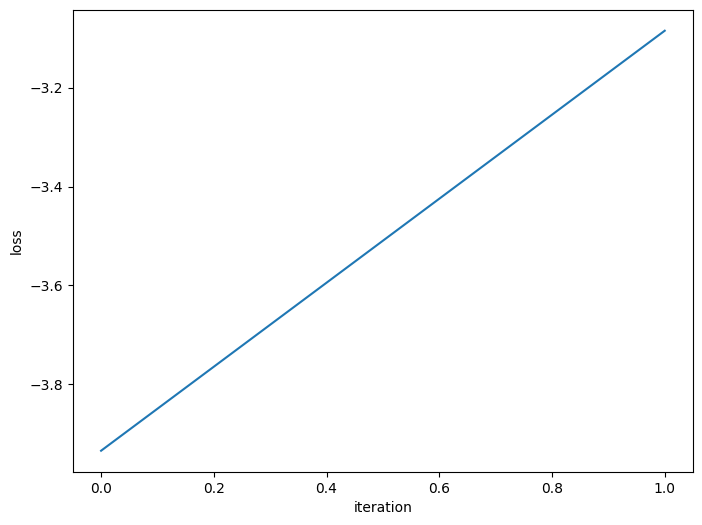

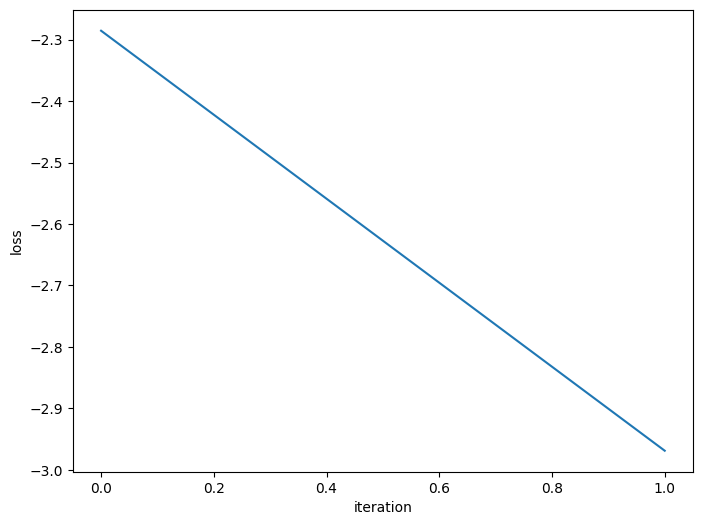

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -564.87189  validloss -647.68274±0.00000  bestvalidloss -647.68274  last_update 0
train: iter 1  trainloss -593.50680  validloss -668.30443±0.00000  bestvalidloss -668.30443  last_update 0
train: iter 2  trainloss -591.68446  validloss -656.47790±0.00000  bestvalidloss -668.30443  last_update 1
train: iter 3  trainloss -528.88767  validloss -667.42765±0.00000  bestvalidloss -668.30443  last_update 2
train: iter 4  trainloss -589.27999  validloss -591.93397±0.00000  bestvalidloss -668.30443  last_update 3
train: iter 5  trainloss -582.29972  validloss -663.95735±0.00000  bestvalidloss -668.30443  last_update 4
train: iter 6  trainloss -599.80848  validloss -680.70018±0.00000  bestvalidloss -680.70018  last_update 0
train: iter 7  trainloss -599.62066  validloss -654.05571±0.00000  bestvalidloss -680.70018  last_update 1
train: iter 8  trainloss -573.50322  validloss -629.45687±0.00000  bestvalidloss -680.70018  last_u

train: iter 76  trainloss -599.29070  validloss -638.76027±0.00000  bestvalidloss -683.71096  last_update 13
train: iter 77  trainloss -549.47899  validloss -654.66093±0.00000  bestvalidloss -683.71096  last_update 14
train: iter 78  trainloss -604.90583  validloss -679.91125±0.00000  bestvalidloss -683.71096  last_update 15
train: iter 79  trainloss -595.30826  validloss -671.30120±0.00000  bestvalidloss -683.71096  last_update 16
train: iter 80  trainloss -599.57706  validloss -660.95318±0.00000  bestvalidloss -683.71096  last_update 17
train: iter 81  trainloss -597.41576  validloss -574.51349±0.00000  bestvalidloss -683.71096  last_update 18
train: iter 82  trainloss -611.83375  validloss -679.96535±0.00000  bestvalidloss -683.71096  last_update 19
train: iter 83  trainloss -613.03891  validloss -678.96012±0.00000  bestvalidloss -683.71096  last_update 20
train: iter 84  trainloss -612.60946  validloss -686.12154±0.00000  bestvalidloss -686.12154  last_update 0
train: iter 85  trai

train: iter 151  trainloss -511.60880  validloss -660.41132±0.00000  bestvalidloss -695.77696  last_update 13
train: iter 152  trainloss -600.24044  validloss -641.64278±0.00000  bestvalidloss -695.77696  last_update 14
train: iter 153  trainloss -577.25735  validloss -688.73228±0.00000  bestvalidloss -695.77696  last_update 15
train: iter 154  trainloss -595.77559  validloss -677.95574±0.00000  bestvalidloss -695.77696  last_update 16
train: iter 155  trainloss -601.59054  validloss -559.24839±0.00000  bestvalidloss -695.77696  last_update 17
train: iter 156  trainloss -609.85701  validloss -659.60816±0.00000  bestvalidloss -695.77696  last_update 18
train: iter 157  trainloss -596.55615  validloss -690.04033±0.00000  bestvalidloss -695.77696  last_update 19
train: iter 158  trainloss -602.92409  validloss -683.54845±0.00000  bestvalidloss -695.77696  last_update 20
train: iter 159  trainloss -603.84400  validloss -665.13209±0.00000  bestvalidloss -695.77696  last_update 21
train: ite

train: iter 226  trainloss -606.26173  validloss -675.37034±0.00000  bestvalidloss -707.96995  last_update 20
train: iter 227  trainloss -613.71479  validloss -706.19840±0.00000  bestvalidloss -707.96995  last_update 21
train: iter 228  trainloss -620.48032  validloss -674.30491±0.00000  bestvalidloss -707.96995  last_update 22
train: iter 229  trainloss -478.00506  validloss -668.64387±0.00000  bestvalidloss -707.96995  last_update 23
train: iter 230  trainloss -584.58690  validloss -656.72481±0.00000  bestvalidloss -707.96995  last_update 24
train: iter 231  trainloss -599.38917  validloss -685.76874±0.00000  bestvalidloss -707.96995  last_update 25
train: iter 232  trainloss -608.36877  validloss -685.56518±0.00000  bestvalidloss -707.96995  last_update 26
train: iter 233  trainloss -587.06240  validloss -682.83345±0.00000  bestvalidloss -707.96995  last_update 27
train: iter 234  trainloss -613.17067  validloss -623.41161±0.00000  bestvalidloss -707.96995  last_update 28
train: ite

train: iter 301  trainloss -629.76819  validloss -721.42392±0.00000  bestvalidloss -726.42724  last_update 30
train: iter 302  trainloss -622.40785  validloss -704.99109±0.00000  bestvalidloss -726.42724  last_update 31
train: iter 303  trainloss -635.05787  validloss -713.43814±0.00000  bestvalidloss -726.42724  last_update 32
train: iter 304  trainloss -513.83104  validloss -692.32365±0.00000  bestvalidloss -726.42724  last_update 33
train: iter 305  trainloss -620.12975  validloss -705.45522±0.00000  bestvalidloss -726.42724  last_update 34
train: iter 306  trainloss -624.63414  validloss -712.92573±0.00000  bestvalidloss -726.42724  last_update 35
train: iter 307  trainloss -616.60080  validloss -683.16759±0.00000  bestvalidloss -726.42724  last_update 36
train: iter 308  trainloss -630.25937  validloss -681.99061±0.00000  bestvalidloss -726.42724  last_update 37
train: iter 309  trainloss -635.94894  validloss -700.39261±0.00000  bestvalidloss -726.42724  last_update 38
train: ite

train: iter 376  trainloss -665.35601  validloss -718.69166±0.00000  bestvalidloss -756.29059  last_update 36
train: iter 377  trainloss -640.96201  validloss -723.87876±0.00000  bestvalidloss -756.29059  last_update 37
train: iter 378  trainloss -626.77936  validloss -719.51090±0.00000  bestvalidloss -756.29059  last_update 38
train: iter 379  trainloss -536.97696  validloss -715.11402±0.00000  bestvalidloss -756.29059  last_update 39
train: iter 380  trainloss 106.68840  validloss -595.23084±0.00000  bestvalidloss -756.29059  last_update 40
train: iter 381  trainloss -534.77214  validloss -60.59347±0.00000  bestvalidloss -756.29059  last_update 41
train: iter 382  trainloss -609.99346  validloss -727.77133±0.00000  bestvalidloss -756.29059  last_update 42
train: iter 383  trainloss -619.57913  validloss -709.47405±0.00000  bestvalidloss -756.29059  last_update 43
train: iter 384  trainloss -625.77469  validloss -717.08516±0.00000  bestvalidloss -756.29059  last_update 44
train: iter 

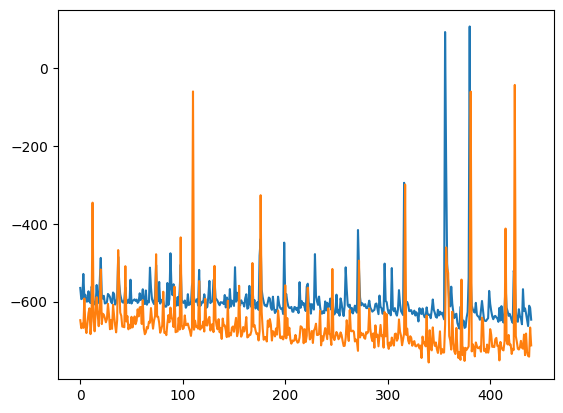

alpha 0.2 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-08-21 15:38:26.904902


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3
predict diverge [-37.48548718  -8.55623109 -96.5710946  -38.72812254] [-0.50064948  0.31325622 -2.0352095  -0.85162049] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 117

 4
predict diverge [-30.25039938  -0.54333758 -85.8413484  -38.73316276] [-0.3170416   0.31221832 -1.6327759  -1.45988062] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 160

 5
predict diverge [-28.90395897  -3.23352098 -67.46399472 -37.96075585] [-0.14510288  1.22190857 -1.85821379 -0.88854143] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 170

 6
predict diverge [ -29.32262016   -5.4636741  -108.06744049  -38.116008  ] [ 0.63275227 -0.15786461 -1.81942664 -1.31007627] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 144

 7
predict diverge [-36.10597615   3.93951238 -90.0

predict diverge [-33.26402798  -3.27241532 -73.03957152 -37.92216469] [-0.32231348 -0.19349213 -1.94763828 -0.60265719] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 170
predict diverge [-32.28127652   0.83997966 -82.28718468 -38.25210021] [-0.19823156 -0.2866991  -1.95476694 -1.34735038] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 123

 31
predict diverge [-37.65878035  -4.5132227  -90.63677829 -38.16973034] [-0.91645111 -0.15137586 -1.86354008 -0.9084037 ] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 172

 32
predict diverge [-32.94237901  -5.07360579 -79.50649914 -38.2836772 ] [-0.34411643 -0.28666284 -1.83229564 -1.49048585] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 158
predict diverge [-27.85066237   7.11700467 -89.07405965 -38.08239468] [ 0.

predict diverge [-33.48353229  -6.38580762 -89.22617924 -38.81228075] [-0.90954283 -0.13995138 -1.95715574 -1.29349236] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 183

 62
predict diverge [ -40.29235843   -1.55791757 -112.55120807  -38.41185746] [-3.07942815 -0.60509827 -1.2313242  -0.87091823] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 189

 63
predict diverge [-26.74465134   5.90700228 -99.57400523 -38.09536581] [ 0.75918064 -2.6562751  -1.91260703 -1.11010792] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 168

 64
predict diverge [-31.98659     -4.31808775 -84.90428205 -38.68916869] [-0.08532859 -1.41989583 -1.90318114 -0.94681717] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 179
predict diverge [-29.4351744   -6.41369709 -85.43466858 -38.64071


 86
predict diverge [-30.13860541  -0.72231084 -93.94538723 -38.02467397] [-0.92519471  0.13176679 -1.79415536 -2.14976324] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 157
predict diverge [-37.71642735  -5.84745863 -93.77950816 -39.63442928] [-0.25205984 -0.62840843 -1.49791017 -2.09435839] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 177

 87
predict diverge [-14.26040723  -3.55272517 -98.90728723 -38.76422668] [ 0.27702489 -0.01958314 -1.78883839 -0.92033869] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 140
predict diverge [ -4.53453457  13.08365379 -89.43352052 -38.19822854] [ 0.62109986 -3.29749568 -1.87353057 -0.43983226] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 122
predict diverge [-12.8488359    2.49566454 -90.75275369 -38.5400616 ] [-0.

In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.61581  validloss 1.08032±0.00000  bestvalidloss 1.08032  last_update 0
train: iter 1  trainloss 0.50150  validloss 0.64071±0.00000  bestvalidloss 0.64071  last_update 0
train: iter 2  trainloss 0.47506  validloss 0.61783±0.00000  bestvalidloss 0.61783  last_update 0
train: iter 3  trainloss 0.46300  validloss 0.60715±0.00000  bestvalidloss 0.60715  last_update 0
train: iter 4  trainloss 0.45028  validloss 0.60445±0.00000  bestvalidloss 0.60445  last_update 0
train: iter 5  trainloss 0.44216  validloss 0.60104±0.00000  bestvalidloss 0.60104  last_update 0
train: iter 6  trainloss 0.43779  validloss 0.60829±0.00000  bestvalidloss 0.60104  last_update 1
train: iter 7  trainloss 0.43032  validloss 0.59034±0.00000  bestvalidloss 0.59034  last_update 0
train: iter 8  trainloss 0.42819  validloss 0.59923±0.00000  bestvalidloss 0.59034  last_update 1
train: iter 9  trainloss 0.42366  validloss 0.58778±0.00000  bestvalidloss 0.58778  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.35616  validloss 0.55009±0.00000  bestvalidloss 0.53574  last_update 30
train: iter 84  trainloss 0.35644  validloss 0.55654±0.00000  bestvalidloss 0.53574  last_update 31
train: iter 85  trainloss 0.35631  validloss 0.54243±0.00000  bestvalidloss 0.53574  last_update 32
train: iter 86  trainloss 0.35429  validloss 0.55732±0.00000  bestvalidloss 0.53574  last_update 33
train: iter 87  trainloss 0.35615  validloss 0.55442±0.00000  bestvalidloss 0.53574  last_update 34
train: iter 88  trainloss 0.35365  validloss 0.56125±0.00000  bestvalidloss 0.53574  last_update 35
train: iter 89  trainloss 0.35354  validloss 0.57990±0.00000  bestvalidloss 0.53574  last_update 36
train: iter 90  trainloss 0.35450  validloss 0.56777±0.00000  bestvalidloss 0.53574  last_update 37
train: iter 91  trainloss 0.35308  validloss 0.55124±0.00000  bestvalidloss 0.53574  last_update 38
train: iter 92  trainloss 0.35452  validloss 0.55576±0.00000  bestvalidloss 0.53574  last_update 39


train_loss:  -3.6829538386136287
valid_loss:  -6.231288476371764
weight_alpha 1.0 h_min_tilde -11.737913 ell_tilde -4.1926207661652555 kappa_tilde 0.00018202538910052116
train_loss:  -3.004475992965698
valid_loss:  -3.2970664432525636
weight_alpha 0.2 h_min_tilde -11.737913 ell_tilde -3.0629940830230713 kappa_tilde 0.00016976075143468417


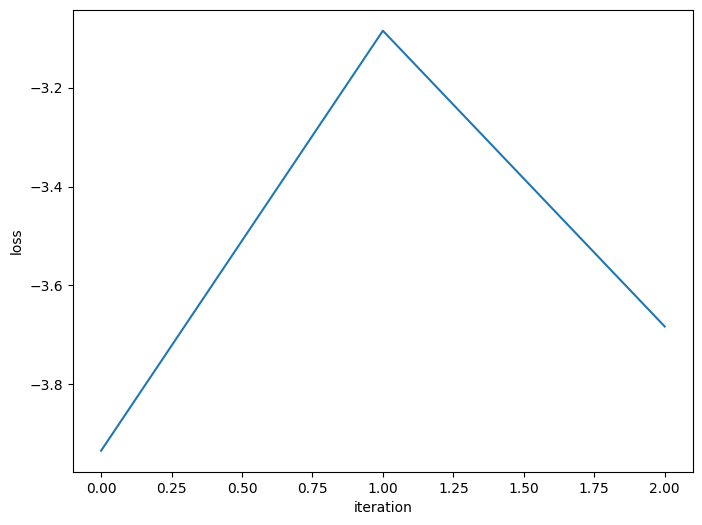

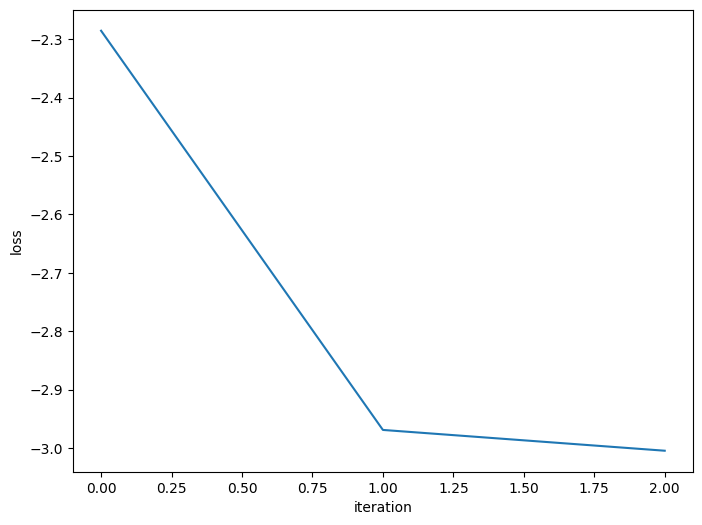

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -582.09474  validloss -662.10759±0.00000  bestvalidloss -662.10759  last_update 0
train: iter 1  trainloss -604.93474  validloss -670.48698±0.00000  bestvalidloss -670.48698  last_update 0
train: iter 2  trainloss -542.19802  validloss -639.93584±0.00000  bestvalidloss -670.48698  last_update 1
train: iter 3  trainloss -587.11253  validloss -637.01285±0.00000  bestvalidloss -670.48698  last_update 2
train: iter 4  trainloss -585.61212  validloss -654.49171±0.00000  bestvalidloss -670.48698  last_update 3
train: iter 5  trainloss -598.28596  validloss -661.50340±0.00000  bestvalidloss -670.48698  last_update 4
train: iter 6  trainloss -551.84582  validloss -643.40958±0.00000  bestvalidloss -670.48698  last_update 5
train: iter 7  trainloss -587.62715  validloss -637.81925±0.00000  bestvalidloss -670.48698  last_update 6
train: iter 8  trainloss -593.62929  validloss -620.98081±0.00000  bestvalidloss -670.48698  last_u

train: iter 76  trainloss -602.22439  validloss -664.62384±0.00000  bestvalidloss -708.74755  last_update 38
train: iter 77  trainloss -614.73780  validloss -678.71487±0.00000  bestvalidloss -708.74755  last_update 39
train: iter 78  trainloss -590.47739  validloss -696.29380±0.00000  bestvalidloss -708.74755  last_update 40
train: iter 79  trainloss -517.54752  validloss -326.01711±0.00000  bestvalidloss -708.74755  last_update 41
train: iter 80  trainloss -597.14694  validloss -661.66650±0.00000  bestvalidloss -708.74755  last_update 42
train: iter 81  trainloss -600.90743  validloss -657.81865±0.00000  bestvalidloss -708.74755  last_update 43
train: iter 82  trainloss -594.20708  validloss -652.06963±0.00000  bestvalidloss -708.74755  last_update 44
train: iter 83  trainloss -583.26452  validloss -588.93485±0.00000  bestvalidloss -708.74755  last_update 45
train: iter 84  trainloss -606.01382  validloss -649.53718±0.00000  bestvalidloss -708.74755  last_update 46
train: iter 85  tra

train: iter 151  trainloss -587.64963  validloss -630.50637±0.00000  bestvalidloss -711.78834  last_update 21
train: iter 152  trainloss -593.28251  validloss -626.90818±0.00000  bestvalidloss -711.78834  last_update 22
train: iter 153  trainloss -614.01078  validloss -675.46419±0.00000  bestvalidloss -711.78834  last_update 23
train: iter 154  trainloss -602.86449  validloss -673.04648±0.00000  bestvalidloss -711.78834  last_update 24
train: iter 155  trainloss -602.17712  validloss -642.07537±0.00000  bestvalidloss -711.78834  last_update 25
train: iter 156  trainloss -611.46823  validloss -684.48223±0.00000  bestvalidloss -711.78834  last_update 26
train: iter 157  trainloss -510.56926  validloss -603.30707±0.00000  bestvalidloss -711.78834  last_update 27
train: iter 158  trainloss -600.86009  validloss -680.65938±0.00000  bestvalidloss -711.78834  last_update 28
train: iter 159  trainloss -604.82739  validloss -682.48674±0.00000  bestvalidloss -711.78834  last_update 29
train: ite

train: iter 226  trainloss -612.21081  validloss -666.74564±0.00000  bestvalidloss -714.89289  last_update 20
train: iter 227  trainloss -613.84307  validloss -676.26694±0.00000  bestvalidloss -714.89289  last_update 21
train: iter 228  trainloss -610.35645  validloss -643.97860±0.00000  bestvalidloss -714.89289  last_update 22
train: iter 229  trainloss -608.69122  validloss -646.91128±0.00000  bestvalidloss -714.89289  last_update 23
train: iter 230  trainloss -623.64528  validloss -720.23824±0.00000  bestvalidloss -720.23824  last_update 0
train: iter 231  trainloss -511.61271  validloss -681.31131±0.00000  bestvalidloss -720.23824  last_update 1
train: iter 232  trainloss -568.30268  validloss -500.19074±0.00000  bestvalidloss -720.23824  last_update 2
train: iter 233  trainloss -606.76834  validloss -653.71030±0.00000  bestvalidloss -720.23824  last_update 3
train: iter 234  trainloss -611.19609  validloss -667.25330±0.00000  bestvalidloss -720.23824  last_update 4
train: iter 235

train: iter 301  trainloss -601.70327  validloss -623.65710±0.00000  bestvalidloss -720.23824  last_update 71
train: iter 302  trainloss -626.00738  validloss -662.57491±0.00000  bestvalidloss -720.23824  last_update 72
train: iter 303  trainloss -559.06390  validloss -717.52797±0.00000  bestvalidloss -720.23824  last_update 73
train: iter 304  trainloss -545.16605  validloss -464.23502±0.00000  bestvalidloss -720.23824  last_update 74
train: iter 305  trainloss -611.00161  validloss -668.10332±0.00000  bestvalidloss -720.23824  last_update 75
train: iter 306  trainloss -570.97553  validloss -688.53595±0.00000  bestvalidloss -720.23824  last_update 76
train: iter 307  trainloss -597.95935  validloss -632.76637±0.00000  bestvalidloss -720.23824  last_update 77
train: iter 308  trainloss -614.57797  validloss -680.11395±0.00000  bestvalidloss -720.23824  last_update 78
train: iter 309  trainloss -619.09530  validloss -676.84019±0.00000  bestvalidloss -720.23824  last_update 79
train: ite

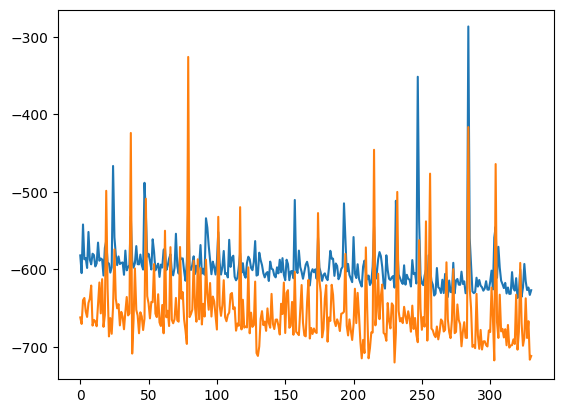

alpha 0.2 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-21 16:04:03.923100


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0
predict diverge [ -47.74031911   -5.88029444 -112.53382498  -38.85791529] [-0.0333457   0.22310763 -1.29155505 -5.05208899] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 163
predict diverge [-38.21461543  -6.94284577 -99.36176801 -40.7265519 ] [-0.32653307 -0.60589953 -1.22971181 -4.36782647] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 168

 1
predict diverge [ -48.98322378   -5.60599778 -114.86163939  -42.12041156] [ -0.19133704   0.57480197  -0.44967444 -13.36805079] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 153

 2
predict diverge [ -43.35768653   -4.0383179  -110.88471595  -38.45200379] [-0.32107083  0.98270901 -1.53681333 -2.32564334] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 167

 3

 4

 5
predict diverge [-37.60692963  -4.36024827 -


 39
predict diverge [ -53.48982992  -12.00219321 -116.43341636  -39.20607555] [-0.60463022  0.35796941 -1.68720869 -2.16109879] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 157
predict diverge [ -45.51013108  -12.06555336 -105.81766416  -38.34931447] [-0.607787   -0.15947563 -1.34531211 -6.47777132] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 146

 40

 41
predict diverge [ -49.93704797  -10.9423226  -106.38338066  -38.64982358] [-0.60605484  0.33896386 -1.64506686 -3.09151481] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 141

 42
predict diverge [ -48.11507172  -12.06937372 -120.54544333  -41.75367786] [-0.68824486  0.53163279 -1.98786054 -5.97364694] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 175

 43

 44

 45

 46
predict diverge [-36.4985245

predict diverge [ -38.88029628   -6.14418434 -122.33310702  -39.68817887] [-0.07528757 -0.40985197 -1.66032718 -3.10436214] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 153

 89

 90
predict diverge [ -35.48842301   16.39184811 -124.19602557  -39.70068397] [ 0.3962744   9.16133214 -0.47439259 -3.7185581 ] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 157
predict diverge [-1.38647953e+01 -9.94445021e-02 -1.19242729e+02 -4.17631283e+01] [ 0.1866369  -1.77115576 -1.62416062 -7.52332424] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 198

 91

 92
predict diverge [-33.16921415  -5.22555221 -94.55759675 -39.15364031] [-0.25748166 -1.74710462 -1.3530328  -3.03201605] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 114

 93

 94
predict diverge [  5.62012679   9.

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.48476  validloss 0.60036±0.00000  bestvalidloss 0.60036  last_update 0
train: iter 1  trainloss 0.44122  validloss 0.51265±0.00000  bestvalidloss 0.51265  last_update 0
train: iter 2  trainloss 0.43633  validloss 0.48995±0.00000  bestvalidloss 0.48995  last_update 0
train: iter 3  trainloss 0.41730  validloss 0.48972±0.00000  bestvalidloss 0.48972  last_update 0
train: iter 4  trainloss 0.41209  validloss 0.50539±0.00000  bestvalidloss 0.48972  last_update 1
train: iter 5  trainloss 0.41324  validloss 0.48262±0.00000  bestvalidloss 0.48262  last_update 0
train: iter 6  trainloss 0.40329  validloss 0.48386±0.00000  bestvalidloss 0.48262  last_update 1
train: iter 7  trainloss 0.40137  validloss 0.48646±0.00000  bestvalidloss 0.48262  last_update 2
train: iter 8  trainloss 0.40472  validloss 0.49175±0.00000  bestvalidloss 0.48262  last_update 3
train: iter 9  trainloss 0.39875  validloss 0.48393±0.00000  bestvalidloss 0.48262  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.34723  validloss 0.47736±0.00000  bestvalidloss 0.46939  last_update 69
train: iter 84  trainloss 0.34334  validloss 0.47947±0.00000  bestvalidloss 0.46939  last_update 70
train: iter 85  trainloss 0.33978  validloss 0.47691±0.00000  bestvalidloss 0.46939  last_update 71
train: iter 86  trainloss 0.34299  validloss 0.51838±0.00000  bestvalidloss 0.46939  last_update 72
train: iter 87  trainloss 0.34550  validloss 0.50904±0.00000  bestvalidloss 0.46939  last_update 73
train: iter 88  trainloss 0.34227  validloss 0.48114±0.00000  bestvalidloss 0.46939  last_update 74
train: iter 89  trainloss 0.34209  validloss 0.50019±0.00000  bestvalidloss 0.46939  last_update 75
train: iter 90  trainloss 0.34384  validloss 0.47433±0.00000  bestvalidloss 0.46939  last_update 76
train: iter 91  trainloss 0.33773  validloss 0.49604±0.00000  bestvalidloss 0.46939  last_update 77
train: iter 92  trainloss 0.34116  validloss 0.48455±0.00000  bestvalidloss 0.46939  last_update 78


train_loss:  -2.8064877590507273
valid_loss:  -2.480841988325119
weight_alpha 1.0 h_min_tilde -11.639202 ell_tilde -2.7413586049056056 kappa_tilde 0.000167620689425254
train_loss:  -2.287357557830215
valid_loss:  -1.986785455298424
weight_alpha 0.2 h_min_tilde -11.639202 ell_tilde -2.227243137323857 kappa_tilde 0.00016297837806430408


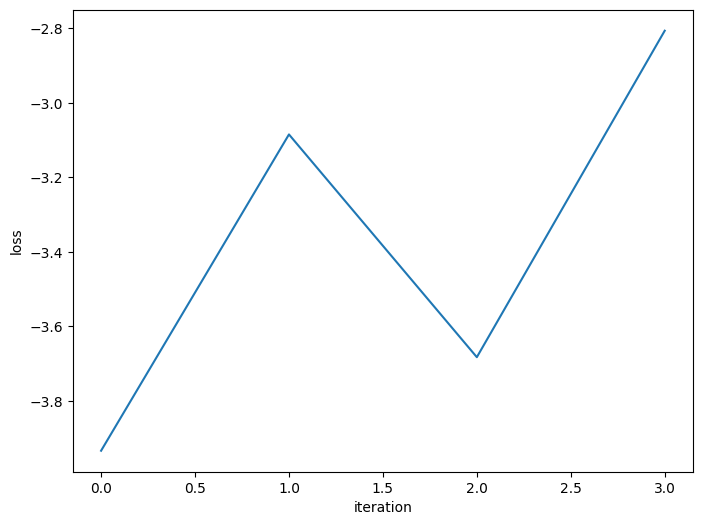

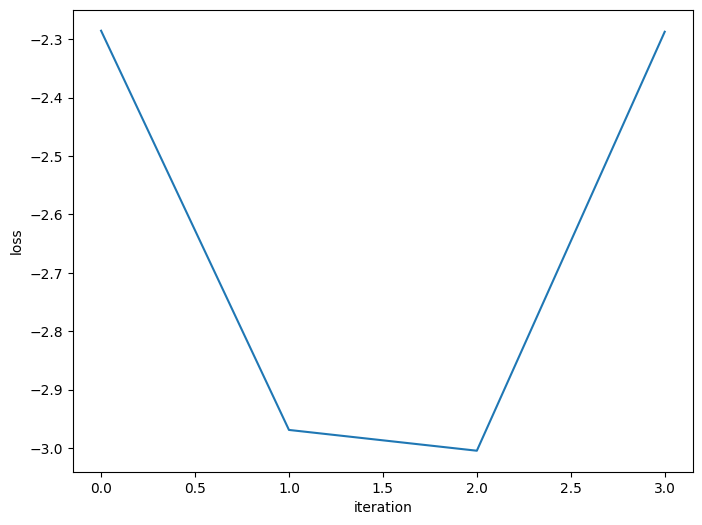

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -493.40628  validloss -419.03501±0.00000  bestvalidloss -419.03501  last_update 0
train: iter 1  trainloss -519.67134  validloss -600.56978±0.00000  bestvalidloss -600.56978  last_update 0
train: iter 2  trainloss -506.63373  validloss -537.01877±0.00000  bestvalidloss -600.56978  last_update 1
train: iter 3  trainloss -513.16602  validloss -602.73114±0.00000  bestvalidloss -602.73114  last_update 0
train: iter 4  trainloss -429.74663  validloss -493.17891±0.00000  bestvalidloss -602.73114  last_update 1
train: iter 5  trainloss -478.58926  validloss -514.15543±0.00000  bestvalidloss -602.73114  last_update 2
train: iter 6  trainloss -498.63554  validloss -573.86974±0.00000  bestvalidloss -602.73114  last_update 3
train: iter 7  trainloss -507.55640  validloss -579.81059±0.00000  bestvalidloss -602.73114  last_update 4
train: iter 8  trainloss -506.37335  validloss -590.08722±0.00000  bestvalidloss -602.73114  last_u

train: iter 76  trainloss -507.89302  validloss -576.14632±0.00000  bestvalidloss -612.72984  last_update 39
train: iter 77  trainloss -519.18180  validloss -583.25195±0.00000  bestvalidloss -612.72984  last_update 40
train: iter 78  trainloss -512.08386  validloss -587.13768±0.00000  bestvalidloss -612.72984  last_update 41
train: iter 79  trainloss -516.83546  validloss -588.11597±0.00000  bestvalidloss -612.72984  last_update 42
train: iter 80  trainloss -464.21718  validloss -598.17261±0.00000  bestvalidloss -612.72984  last_update 43
train: iter 81  trainloss -468.05620  validloss -498.42546±0.00000  bestvalidloss -612.72984  last_update 44
train: iter 82  trainloss -499.78753  validloss -535.81857±0.00000  bestvalidloss -612.72984  last_update 45
train: iter 83  trainloss -511.24445  validloss -577.90164±0.00000  bestvalidloss -612.72984  last_update 46
train: iter 84  trainloss -510.81485  validloss -591.36174±0.00000  bestvalidloss -612.72984  last_update 47
train: iter 85  tra

train: iter 151  trainloss -517.01328  validloss -607.21466±0.00000  bestvalidloss -612.87611  last_update 51
train: iter 152  trainloss -514.95840  validloss -581.27105±0.00000  bestvalidloss -612.87611  last_update 52
train: iter 153  trainloss -515.50750  validloss -601.78099±0.00000  bestvalidloss -612.87611  last_update 53
train: iter 154  trainloss -517.60881  validloss -605.18489±0.00000  bestvalidloss -612.87611  last_update 54
train: iter 155  trainloss -505.84837  validloss -587.31820±0.00000  bestvalidloss -612.87611  last_update 55
train: iter 156  trainloss -519.94565  validloss -546.58022±0.00000  bestvalidloss -612.87611  last_update 56
train: iter 157  trainloss -525.40791  validloss -580.35154±0.00000  bestvalidloss -612.87611  last_update 57
train: iter 158  trainloss -523.26352  validloss -592.33665±0.00000  bestvalidloss -612.87611  last_update 58
train: iter 159  trainloss -478.88791  validloss -600.97833±0.00000  bestvalidloss -612.87611  last_update 59
train: ite

train: iter 226  trainloss -497.49381  validloss -571.88937±0.00000  bestvalidloss -627.43578  last_update 28
train: iter 227  trainloss -461.79162  validloss -503.23214±0.00000  bestvalidloss -627.43578  last_update 29
train: iter 228  trainloss -526.70213  validloss -599.51236±0.00000  bestvalidloss -627.43578  last_update 30
train: iter 229  trainloss -539.21465  validloss -601.16197±0.00000  bestvalidloss -627.43578  last_update 31
train: iter 230  trainloss -529.85130  validloss -599.10226±0.00000  bestvalidloss -627.43578  last_update 32
train: iter 231  trainloss -526.90498  validloss -606.34884±0.00000  bestvalidloss -627.43578  last_update 33
train: iter 232  trainloss -509.23782  validloss -569.90224±0.00000  bestvalidloss -627.43578  last_update 34
train: iter 233  trainloss -530.16044  validloss -603.87085±0.00000  bestvalidloss -627.43578  last_update 35
train: iter 234  trainloss -536.08258  validloss -607.19413±0.00000  bestvalidloss -627.43578  last_update 36
train: ite

train: iter 301  trainloss -521.40800  validloss -581.51380±0.00000  bestvalidloss -633.92098  last_update 3
train: iter 302  trainloss -526.16871  validloss -602.13334±0.00000  bestvalidloss -633.92098  last_update 4
train: iter 303  trainloss -534.17423  validloss -603.63122±0.00000  bestvalidloss -633.92098  last_update 5
train: iter 304  trainloss -513.94608  validloss -608.52923±0.00000  bestvalidloss -633.92098  last_update 6
train: iter 305  trainloss -518.77075  validloss -605.17221±0.00000  bestvalidloss -633.92098  last_update 7
train: iter 306  trainloss -530.14656  validloss -613.89569±0.00000  bestvalidloss -633.92098  last_update 8
train: iter 307  trainloss -539.93151  validloss -612.44734±0.00000  bestvalidloss -633.92098  last_update 9
train: iter 308  trainloss -546.19490  validloss -619.46638±0.00000  bestvalidloss -633.92098  last_update 10
train: iter 309  trainloss -497.84352  validloss -634.19213±0.00000  bestvalidloss -634.19213  last_update 0
train: iter 310  t

train: iter 376  trainloss -527.16966  validloss -598.85678±0.00000  bestvalidloss -644.66646  last_update 7
train: iter 377  trainloss -520.36317  validloss -620.42494±0.00000  bestvalidloss -644.66646  last_update 8
train: iter 378  trainloss -533.17355  validloss -612.38882±0.00000  bestvalidloss -644.66646  last_update 9
train: iter 379  trainloss -529.24453  validloss -623.66858±0.00000  bestvalidloss -644.66646  last_update 10
train: iter 380  trainloss -512.53037  validloss -591.36466±0.00000  bestvalidloss -644.66646  last_update 11
train: iter 381  trainloss -527.89593  validloss -618.02925±0.00000  bestvalidloss -644.66646  last_update 12
train: iter 382  trainloss -536.65104  validloss -622.51369±0.00000  bestvalidloss -644.66646  last_update 13
train: iter 383  trainloss -535.31867  validloss -626.95345±0.00000  bestvalidloss -644.66646  last_update 14
train: iter 384  trainloss -533.99400  validloss -606.04975±0.00000  bestvalidloss -644.66646  last_update 15
train: iter 3

train: iter 451  trainloss -533.12650  validloss -622.47022±0.00000  bestvalidloss -644.66646  last_update 82
train: iter 452  trainloss -532.85940  validloss -615.71464±0.00000  bestvalidloss -644.66646  last_update 83
train: iter 453  trainloss -495.87789  validloss -609.52187±0.00000  bestvalidloss -644.66646  last_update 84
train: iter 454  trainloss -527.31491  validloss -581.23188±0.00000  bestvalidloss -644.66646  last_update 85
train: iter 455  trainloss -532.89807  validloss -623.38775±0.00000  bestvalidloss -644.66646  last_update 86
train: iter 456  trainloss -517.69219  validloss -622.23296±0.00000  bestvalidloss -644.66646  last_update 87
train: iter 457  trainloss -529.22407  validloss -598.04325±0.00000  bestvalidloss -644.66646  last_update 88
train: iter 458  trainloss -522.83560  validloss -609.50069±0.00000  bestvalidloss -644.66646  last_update 89
train: iter 459  trainloss -532.15881  validloss -611.47047±0.00000  bestvalidloss -644.66646  last_update 90
train: ite

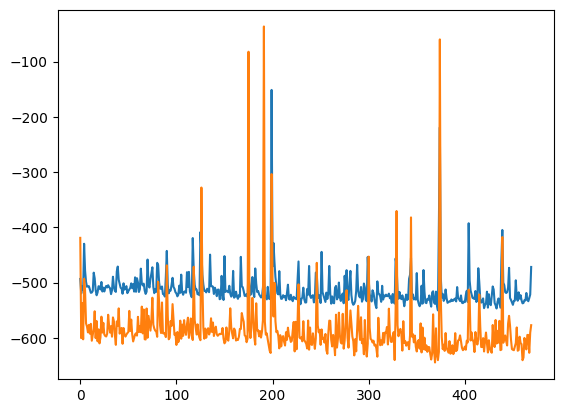

alpha 0.2 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-21 16:31:16.940970


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1
predict diverge [-128.64058475  -14.88033271 -113.95692462  -35.5822958 ] [-5.63401218e+01  1.99121390e-02 -2.23133199e+00 -3.24431681e-01] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 124
predict diverge [-146.89964526  -11.36459331 -104.04127356  -28.02382984] [-43.92849113   0.20357556  -1.41101537  -1.06886827] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 157

 2
predict diverge [-228.06775894   -9.57244332  -96.36619882  -27.6395174 ] [-1.05670941e+02 -3.81881783e-03 -1.32947335e+00 -1.22854143e+00] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 184
predict diverge [  40.51266224  -15.31084182 -149.88277572  -37.89250554] [-1.08493477  0.07228161 -2.00100734 -0.37660864] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 174

 3
predict diverge 

predict diverge [-16.33623705 -12.00451467 -93.54279545 -38.12024905] [ 9.85847401e+00 -4.74271777e-03 -1.86004531e+00 -4.82266296e-01] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 126

 37

 38
predict diverge [  -6.37722002  -16.13417282 -138.30500853  -38.50988529] [-1.72613233  0.01409769 -1.96681219 -1.082938  ] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 194

 39
predict diverge [  -1.99219573  -10.84679627 -148.83921074  -37.93738028] [-5.0774622  -0.06001152 -1.91119066 -0.41179684] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 175
predict diverge [-146.69654673  -15.49140977 -118.13730327  -32.51968996] [-60.11407761   0.15204765  -1.7257625   -0.70642119] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 196

 40

 41
predict diverge [  42.94149


 72
predict diverge [  16.45311337  -14.50187027 -128.16350672  -37.89167688] [ 8.77390501 -0.01960538 -1.87740631 -0.4673289 ] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 155

 73
predict diverge [-304.8433231    -8.6965527  -122.86336446  -34.78609048] [-2.46679370e+02 -1.79763342e-01 -1.51752744e+00 -2.23823911e+00] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 170

 74

 75

 76
predict diverge [-125.44131097  -12.15406136  -97.8908691   -30.79279906] [-17.92742216   0.41133327  -2.11462469   0.30241553] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 153
predict diverge [-2.01052474  2.09923085 48.01878838 38.45850658] [0.09243279 7.02563104 1.42976777 9.96693301] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 159

 77
predict diverge [  72.4663626 

In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.61268  validloss 0.91628±0.00000  bestvalidloss 0.91628  last_update 0
train: iter 1  trainloss 0.53537  validloss 0.75804±0.00000  bestvalidloss 0.75804  last_update 0
train: iter 2  trainloss 0.51485  validloss 0.69755±0.00000  bestvalidloss 0.69755  last_update 0
train: iter 3  trainloss 0.49932  validloss 0.67585±0.00000  bestvalidloss 0.67585  last_update 0
train: iter 4  trainloss 0.48304  validloss 0.64363±0.00000  bestvalidloss 0.64363  last_update 0
train: iter 5  trainloss 0.47221  validloss 0.63796±0.00000  bestvalidloss 0.63796  last_update 0
train: iter 6  trainloss 0.46400  validloss 0.62545±0.00000  bestvalidloss 0.62545  last_update 0
train: iter 7  trainloss 0.46280  validloss 0.60011±0.00000  bestvalidloss 0.60011  last_update 0
train: iter 8  trainloss 0.45889  validloss 0.58961±0.00000  bestvalidloss 0.58961  last_update 0
train: iter 9  trainloss 0.44941  validloss 0.59418±0.00000  bestvalidloss 0.58961  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.38769  validloss 0.54339±0.00000  bestvalidloss 0.53219  last_update 23
train: iter 84  trainloss 0.38404  validloss 0.53811±0.00000  bestvalidloss 0.53219  last_update 24
train: iter 85  trainloss 0.38545  validloss 0.53843±0.00000  bestvalidloss 0.53219  last_update 25
train: iter 86  trainloss 0.38123  validloss 0.54460±0.00000  bestvalidloss 0.53219  last_update 26
train: iter 87  trainloss 0.38423  validloss 0.54754±0.00000  bestvalidloss 0.53219  last_update 27
train: iter 88  trainloss 0.38043  validloss 0.53299±0.00000  bestvalidloss 0.53219  last_update 28
train: iter 89  trainloss 0.38843  validloss 0.55355±0.00000  bestvalidloss 0.53219  last_update 29
train: iter 90  trainloss 0.38128  validloss 0.55689±0.00000  bestvalidloss 0.53219  last_update 30
train: iter 91  trainloss 0.38364  validloss 0.54163±0.00000  bestvalidloss 0.53219  last_update 31
train: iter 92  trainloss 0.37958  validloss 0.52859±0.00000  bestvalidloss 0.52859  last_update 0
t

train: iter 165  trainloss 0.36448  validloss 0.53452±0.00000  bestvalidloss 0.52560  last_update 38
train: iter 166  trainloss 0.36175  validloss 0.54794±0.00000  bestvalidloss 0.52560  last_update 39
train: iter 167  trainloss 0.35891  validloss 0.53843±0.00000  bestvalidloss 0.52560  last_update 40
train: iter 168  trainloss 0.36350  validloss 0.54547±0.00000  bestvalidloss 0.52560  last_update 41
train: iter 169  trainloss 0.36158  validloss 0.54896±0.00000  bestvalidloss 0.52560  last_update 42
train: iter 170  trainloss 0.35998  validloss 0.53932±0.00000  bestvalidloss 0.52560  last_update 43
train: iter 171  trainloss 0.36015  validloss 0.53110±0.00000  bestvalidloss 0.52560  last_update 44
train: iter 172  trainloss 0.36029  validloss 0.55143±0.00000  bestvalidloss 0.52560  last_update 45
train: iter 173  trainloss 0.35870  validloss 0.53385±0.00000  bestvalidloss 0.52560  last_update 46
train: iter 174  trainloss 0.36070  validloss 0.55160±0.00000  bestvalidloss 0.52560  last_

train_loss:  -2.6951950314819815
valid_loss:  -4.775888892710208
weight_alpha 1.0 h_min_tilde -11.235735 ell_tilde -3.1113338037276264 kappa_tilde 0.00017541806869395023
train_loss:  -2.336308159922063
valid_loss:  -2.733623211622238
weight_alpha 0.2 h_min_tilde -11.235735 ell_tilde -2.4157711702620976 kappa_tilde 0.00016835910321744458


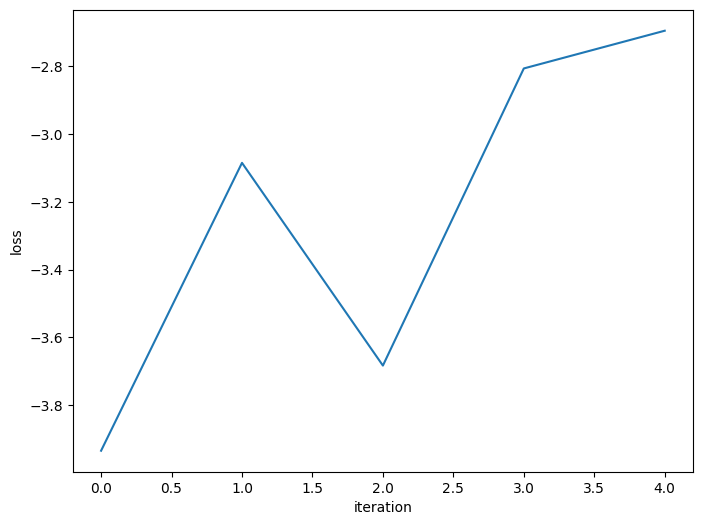

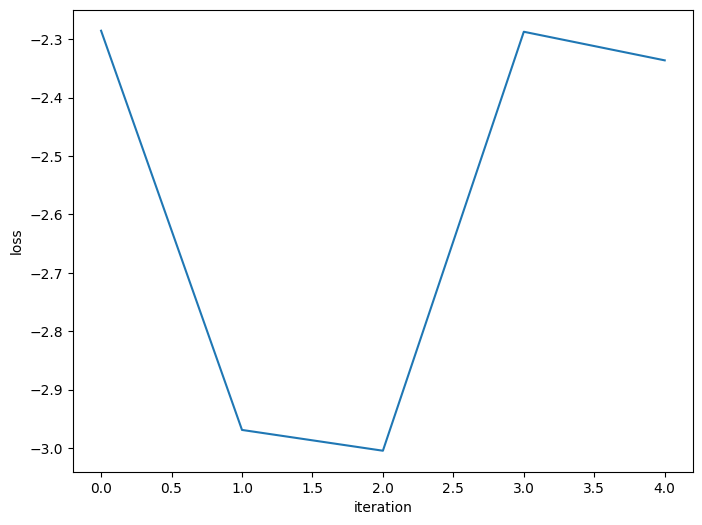

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -560.38110  validloss -554.25484±0.00000  bestvalidloss -554.25484  last_update 0
train: iter 1  trainloss -598.11152  validloss -666.90821±0.00000  bestvalidloss -666.90821  last_update 0
train: iter 2  trainloss -589.12566  validloss -657.62651±0.00000  bestvalidloss -666.90821  last_update 1
train: iter 3  trainloss -596.04540  validloss -680.02787±0.00000  bestvalidloss -680.02787  last_update 0
train: iter 4  trainloss -558.85927  validloss -630.93543±0.00000  bestvalidloss -680.02787  last_update 1
train: iter 5  trainloss -592.93245  validloss -682.23160±0.00000  bestvalidloss -682.23160  last_update 0
train: iter 6  trainloss -595.22063  validloss -696.75262±0.00000  bestvalidloss -696.75262  last_update 0
train: iter 7  trainloss -578.94709  validloss -692.41177±0.00000  bestvalidloss -696.75262  last_update 1
train: iter 8  trainloss -517.53122  validloss -443.77120±0.00000  bestvalidloss -696.75262  last_u

train: iter 76  trainloss -591.93426  validloss -696.47628±0.00000  bestvalidloss -711.87330  last_update 3
train: iter 77  trainloss -592.96657  validloss -693.43734±0.00000  bestvalidloss -711.87330  last_update 4
train: iter 78  trainloss -596.80895  validloss -705.76296±0.00000  bestvalidloss -711.87330  last_update 5
train: iter 79  trainloss -584.60496  validloss -696.51017±0.00000  bestvalidloss -711.87330  last_update 6
train: iter 80  trainloss -595.07831  validloss -695.81716±0.00000  bestvalidloss -711.87330  last_update 7
train: iter 81  trainloss -600.78004  validloss -695.51596±0.00000  bestvalidloss -711.87330  last_update 8
train: iter 82  trainloss -600.21613  validloss -705.01443±0.00000  bestvalidloss -711.87330  last_update 9
train: iter 83  trainloss -594.53246  validloss -704.18302±0.00000  bestvalidloss -711.87330  last_update 10
train: iter 84  trainloss -564.42036  validloss -682.35279±0.00000  bestvalidloss -711.87330  last_update 11
train: iter 85  trainloss 

train: iter 151  trainloss -575.66678  validloss -678.27966±0.00000  bestvalidloss -711.87330  last_update 78
train: iter 152  trainloss -616.95128  validloss -702.06141±0.00000  bestvalidloss -711.87330  last_update 79
train: iter 153  trainloss -610.81846  validloss -702.78747±0.00000  bestvalidloss -711.87330  last_update 80
train: iter 154  trainloss -597.99672  validloss -651.03039±0.00000  bestvalidloss -711.87330  last_update 81
train: iter 155  trainloss -583.92159  validloss -645.83554±0.00000  bestvalidloss -711.87330  last_update 82
train: iter 156  trainloss -578.91313  validloss -632.58598±0.00000  bestvalidloss -711.87330  last_update 83
train: iter 157  trainloss -623.98698  validloss -699.12848±0.00000  bestvalidloss -711.87330  last_update 84
train: iter 158  trainloss -608.55447  validloss -693.01052±0.00000  bestvalidloss -711.87330  last_update 85
train: iter 159  trainloss -623.80589  validloss -713.20106±0.00000  bestvalidloss -713.20106  last_update 0
train: iter

train: iter 226  trainloss -629.19834  validloss -663.28262±0.00000  bestvalidloss -727.86588  last_update 34
train: iter 227  trainloss -582.54201  validloss -717.21222±0.00000  bestvalidloss -727.86588  last_update 35
train: iter 228  trainloss -548.29069  validloss -698.70130±0.00000  bestvalidloss -727.86588  last_update 36
train: iter 229  trainloss -609.37905  validloss -687.00427±0.00000  bestvalidloss -727.86588  last_update 37
train: iter 230  trainloss -597.41349  validloss -683.90598±0.00000  bestvalidloss -727.86588  last_update 38
train: iter 231  trainloss -628.57413  validloss -720.74172±0.00000  bestvalidloss -727.86588  last_update 39
train: iter 232  trainloss -623.26434  validloss -698.33461±0.00000  bestvalidloss -727.86588  last_update 40
train: iter 233  trainloss -612.16078  validloss -707.16957±0.00000  bestvalidloss -727.86588  last_update 41
train: iter 234  trainloss -614.21814  validloss -711.96533±0.00000  bestvalidloss -727.86588  last_update 42
train: ite

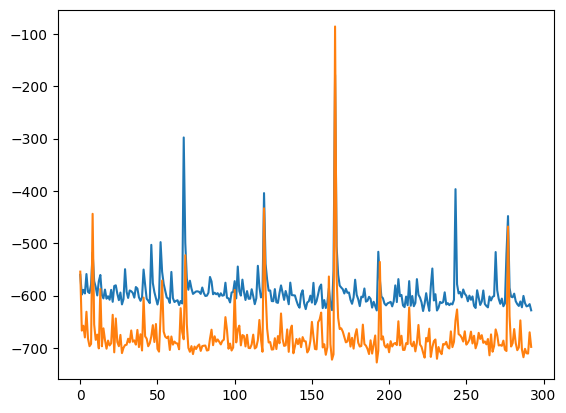

alpha 0.2 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-21 16:55:46.650458


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6
predict diverge [-29.19347643  -4.17793562 -21.68156501  45.86485193] [-0.29595579  0.27089171  1.66276003  8.12160533] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 121

 7

 8

 9

 10

 11

 12
predict diverge [-53.52264847  -6.46214156 -79.65033898  64.6374685 ] [-0.80318479  9.44767592  1.34655654 43.64039254] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 188

 13

 14

 15
predict diverge [-36.2070431   -6.14941332 -68.60209934 -38.43562183] [-0.36674266  2.10118126 -1.78272017 -1.45611601] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.945347] sim_timestep 131

 16

 17

 18

 19

 20

 21

 22
predict diverge [-46.68587353 -15.72915189 -81.59680981 -40.12606582] [-0.753394    0.31845658 -1.67719625 -6.70130429] [123.29585   20.778236 200.49478   37.890694] [ 61.647926  10.389118 100.24739   18.9453

In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.55572  validloss 0.69425±0.00000  bestvalidloss 0.69425  last_update 0
train: iter 1  trainloss 0.48700  validloss 0.59481±0.00000  bestvalidloss 0.59481  last_update 0
train: iter 2  trainloss 0.46649  validloss 0.57708±0.00000  bestvalidloss 0.57708  last_update 0
train: iter 3  trainloss 0.45824  validloss 0.56996±0.00000  bestvalidloss 0.56996  last_update 0
train: iter 4  trainloss 0.44015  validloss 0.56283±0.00000  bestvalidloss 0.56283  last_update 0
train: iter 5  trainloss 0.43265  validloss 0.55153±0.00000  bestvalidloss 0.55153  last_update 0
train: iter 6  trainloss 0.42785  validloss 0.55776±0.00000  bestvalidloss 0.55153  last_update 1
train: iter 7  trainloss 0.42412  validloss 0.54221±0.00000  bestvalidloss 0.54221  last_update 0
train: iter 8  trainloss 0.42434  validloss 0.54407±0.00000  bestvalidloss 0.54221  last_update 1
train: iter 9  trainloss 0.42378  validloss 0.54377±0.00000  bestvalidloss 0.54221  last_update 2
train: iter 10  trai

train: iter 83  trainloss 0.35625  validloss 0.49871±0.00000  bestvalidloss 0.49272  last_update 10
train: iter 84  trainloss 0.35880  validloss 0.49426±0.00000  bestvalidloss 0.49272  last_update 11
train: iter 85  trainloss 0.35575  validloss 0.50808±0.00000  bestvalidloss 0.49272  last_update 12
train: iter 86  trainloss 0.35568  validloss 0.50226±0.00000  bestvalidloss 0.49272  last_update 13
train: iter 87  trainloss 0.35400  validloss 0.49893±0.00000  bestvalidloss 0.49272  last_update 14
train: iter 88  trainloss 0.37270  validloss 0.51620±0.00000  bestvalidloss 0.49272  last_update 15
train: iter 89  trainloss 0.35676  validloss 0.49306±0.00000  bestvalidloss 0.49272  last_update 16
train: iter 90  trainloss 0.35596  validloss 0.51151±0.00000  bestvalidloss 0.49272  last_update 17
train: iter 91  trainloss 0.35719  validloss 0.49810±0.00000  bestvalidloss 0.49272  last_update 18
train: iter 92  trainloss 0.35647  validloss 0.50084±0.00000  bestvalidloss 0.49272  last_update 19


train: iter 165  trainloss 0.34310  validloss 0.50691±0.00000  bestvalidloss 0.48816  last_update 45
train: iter 166  trainloss 0.34391  validloss 0.50150±0.00000  bestvalidloss 0.48816  last_update 46
train: iter 167  trainloss 0.34482  validloss 0.50473±0.00000  bestvalidloss 0.48816  last_update 47
train: iter 168  trainloss 0.33775  validloss 0.50971±0.00000  bestvalidloss 0.48816  last_update 48
train: iter 169  trainloss 0.34273  validloss 0.49794±0.00000  bestvalidloss 0.48816  last_update 49
train: iter 170  trainloss 0.33872  validloss 0.50609±0.00000  bestvalidloss 0.48816  last_update 50
train: iter 171  trainloss 0.33952  validloss 0.51243±0.00000  bestvalidloss 0.48816  last_update 51
train: iter 172  trainloss 0.33786  validloss 0.50064±0.00000  bestvalidloss 0.48816  last_update 52
train: iter 173  trainloss 0.33841  validloss 0.50189±0.00000  bestvalidloss 0.48816  last_update 53
train: iter 174  trainloss 0.34085  validloss 0.51332±0.00000  bestvalidloss 0.48816  last_

([0.5557236971333623,
  0.4869952600449324,
  0.4664938958361745,
  0.4582376811653376,
  0.4401517976075411,
  0.43265418633818625,
  0.4278464637696743,
  0.4241198690608144,
  0.42434199154376984,
  0.42378005012869835,
  0.41690279645845296,
  0.4102769108489156,
  0.4064444964751601,
  0.4090189510956407,
  0.40382085703313353,
  0.40448693055659535,
  0.39956492111086844,
  0.4038580320775509,
  0.39877774380147457,
  0.3942670408636332,
  0.3984832527115941,
  0.3939199397340417,
  0.3946025626733899,
  0.39019367657601833,
  0.38799855802208183,
  0.38620127756148576,
  0.38864754382520916,
  0.38313923329114913,
  0.3827426264062524,
  0.38766278736293314,
  0.3926102780736983,
  0.3897228941321373,
  0.3868643457069993,
  0.38298891643062233,
  0.3778641354292631,
  0.3777345190756023,
  0.3791464390233159,
  0.3755000814795494,
  0.3808713346719742,
  0.37772318068891764,
  0.3764138611033559,
  0.3833451747894287,
  0.3741584558039904,
  0.3764159049838781,
  0.378961294516

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.337295681798458
valid_loss:  -6.014061664581299
weight_alpha 1.0 h_min_tilde -11.726574 ell_tilde -3.8726488783550264 kappa_tilde 0.00017841305412570702
train_loss:  -2.9453628376960754
valid_loss:  -3.3663156120300295
weight_alpha 0.2 h_min_tilde -11.726574 ell_tilde -3.029553392562866 kappa_tilde 0.00016954491001896482


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 54.78101  validloss 61.45860±0.00000  bestvalidloss 61.45860  last_update 0
train: iter 1  trainloss 41.29272  validloss 46.54044±0.00000  bestvalidloss 46.54044  last_update 0
train: iter 2  trainloss 31.77415  validloss 34.45713±0.00000  bestvalidloss 34.45713  last_update 0
train: iter 3  trainloss 24.27799  validloss 25.85903±0.00000  bestvalidloss 25.85903  last_update 0
train: iter 4  trainloss 18.60041  validloss 20.43427±0.00000  bestvalidloss 20.43427  last_update 0
train: iter 5  trainloss 14.48940  validloss 15.04520±0.00000  bestvalidloss 15.04520  last_update 0
train: iter 6  trainloss 10.99530  validloss 11.57906±0.00000  bestvalidloss 11.57906  last_update 0
train: iter 7  trainloss 8.47515  validloss 8.54938±0.00000  bestvalidloss 8.54938  last_update 0
train: iter 8  trainloss 6.31153  validloss 6.07519±0.00000  bestvalidloss 6.07519  last_update 0
train: iter 9  trainloss 4.80859  validloss 4.35205±0.00000  bestvalidloss 4.35205  last_update 0

train: iter 83  trainloss -0.90023  validloss -1.42031±0.00000  bestvalidloss -1.42031  last_update 0
train: iter 84  trainloss -0.91472  validloss -1.40340±0.00000  bestvalidloss -1.42031  last_update 1
train: iter 85  trainloss -0.90101  validloss -1.48431±0.00000  bestvalidloss -1.48431  last_update 0
train: iter 86  trainloss -0.94846  validloss -1.47608±0.00000  bestvalidloss -1.48431  last_update 1
train: iter 87  trainloss -0.95396  validloss -1.44508±0.00000  bestvalidloss -1.48431  last_update 2
train: iter 88  trainloss -0.95858  validloss -1.43302±0.00000  bestvalidloss -1.48431  last_update 3
train: iter 89  trainloss -0.99526  validloss -1.47583±0.00000  bestvalidloss -1.48431  last_update 4
train: iter 90  trainloss -1.01149  validloss -1.45889±0.00000  bestvalidloss -1.48431  last_update 5
train: iter 91  trainloss -1.00125  validloss -1.51175±0.00000  bestvalidloss -1.51175  last_update 0
train: iter 92  trainloss -1.02529  validloss -1.52863±0.00000  bestvalidloss -1.5

train: iter 174  trainloss -1.20404  validloss -1.75164±0.00000  bestvalidloss -1.92289  last_update 21
train: iter 175  trainloss -1.10960  validloss -1.79748±0.00000  bestvalidloss -1.92289  last_update 22
train: iter 176  trainloss -1.20162  validloss -1.84898±0.00000  bestvalidloss -1.92289  last_update 23
train: iter 177  trainloss -1.03326  validloss -1.70866±0.00000  bestvalidloss -1.92289  last_update 24
train: iter 178  trainloss -1.17315  validloss -1.55675±0.00000  bestvalidloss -1.92289  last_update 25
train: iter 179  trainloss -1.22535  validloss -1.64450±0.00000  bestvalidloss -1.92289  last_update 26
train: iter 180  trainloss -1.27974  validloss -1.79007±0.00000  bestvalidloss -1.92289  last_update 27
train: iter 181  trainloss -1.18946  validloss -1.82575±0.00000  bestvalidloss -1.92289  last_update 28
train: iter 182  trainloss -1.24106  validloss -1.80715±0.00000  bestvalidloss -1.92289  last_update 29
train: iter 183  trainloss -1.18330  validloss -1.90517±0.00000 

train: iter 255  trainloss -1.10198  validloss -1.81786±0.00000  bestvalidloss -1.99098  last_update 48
train: iter 256  trainloss -1.14007  validloss -1.76280±0.00000  bestvalidloss -1.99098  last_update 49
train: iter 257  trainloss -1.16758  validloss -1.91962±0.00000  bestvalidloss -1.99098  last_update 50
train: iter 258  trainloss -1.13071  validloss -1.84366±0.00000  bestvalidloss -1.99098  last_update 51
train: iter 259  trainloss -1.15623  validloss -1.87253±0.00000  bestvalidloss -1.99098  last_update 52
train: iter 260  trainloss -1.12125  validloss -1.85883±0.00000  bestvalidloss -1.99098  last_update 53
train: iter 261  trainloss -1.12172  validloss -1.62822±0.00000  bestvalidloss -1.99098  last_update 54
train: iter 262  trainloss -1.13537  validloss -1.70275±0.00000  bestvalidloss -1.99098  last_update 55
train: iter 263  trainloss -1.22172  validloss -1.88369±0.00000  bestvalidloss -1.99098  last_update 56
train: iter 264  trainloss -1.24515  validloss -1.75502±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 1.2358,  0.1417, -6.7830, -1.2559], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 10.60969  validloss 11.48707±0.00000  bestvalidloss 11.48707  last_update 0
train: iter 1  trainloss 7.94992  validloss 7.96526±0.00000  bestvalidloss 7.96526  last_update 0
train: iter 2  trainloss 7.49312  validloss 8.13788±0.00000  bestvalidloss 7.96526  last_update 1
train: iter 3  trainloss 7.12580  validloss 7.90741±0.00000  bestvalidloss 7.90741  last_update 0
train: iter 4  trainloss 6.91033  validloss 7.76582±0.00000  bestvalidloss 7.76582  last_update 0
train: iter 5  trainloss 6.68306  validloss 7.75691±0.00000  bestvalidloss 7.75691  last_update 0
train: iter 6  trainloss 6.56112  validloss 7.48213±0.00000  bestvalidloss 7.48213  last_update 0
train: iter 7  trainloss 6.43225  validloss 7.52254±0.00000  bestvalidloss 7.48213  last_update 1
train: iter 8  trainloss 6.30990  validloss 7.44241±0.00000  bestvalidloss 7.44241  last_update 0
train: iter 9  trainloss 6.23914  validloss 7.40705±0.00000  bestvalidloss 7.40705  last_update 0
train: iter 10  t

train: iter 84  trainloss 5.20773  validloss 7.42258±0.00000  bestvalidloss 6.82155  last_update 45
train: iter 85  trainloss 5.22614  validloss 7.16837±0.00000  bestvalidloss 6.82155  last_update 46
train: iter 86  trainloss 5.22225  validloss 7.09613±0.00000  bestvalidloss 6.82155  last_update 47
train: iter 87  trainloss 5.24195  validloss 7.15697±0.00000  bestvalidloss 6.82155  last_update 48
train: iter 88  trainloss 5.30437  validloss 7.45455±0.00000  bestvalidloss 6.82155  last_update 49
train: iter 89  trainloss 5.19937  validloss 7.60875±0.00000  bestvalidloss 6.82155  last_update 50
train: iter 90  trainloss 5.23204  validloss 7.48314±0.00000  bestvalidloss 6.82155  last_update 51
train: iter 91  trainloss 5.20277  validloss 7.41030±0.00000  bestvalidloss 6.82155  last_update 52
train: iter 92  trainloss 5.20056  validloss 7.44140±0.00000  bestvalidloss 6.82155  last_update 53
train: iter 93  trainloss 5.19997  validloss 7.24499±0.00000  bestvalidloss 6.82155  last_update 54


In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-6.6614)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-21.1284)


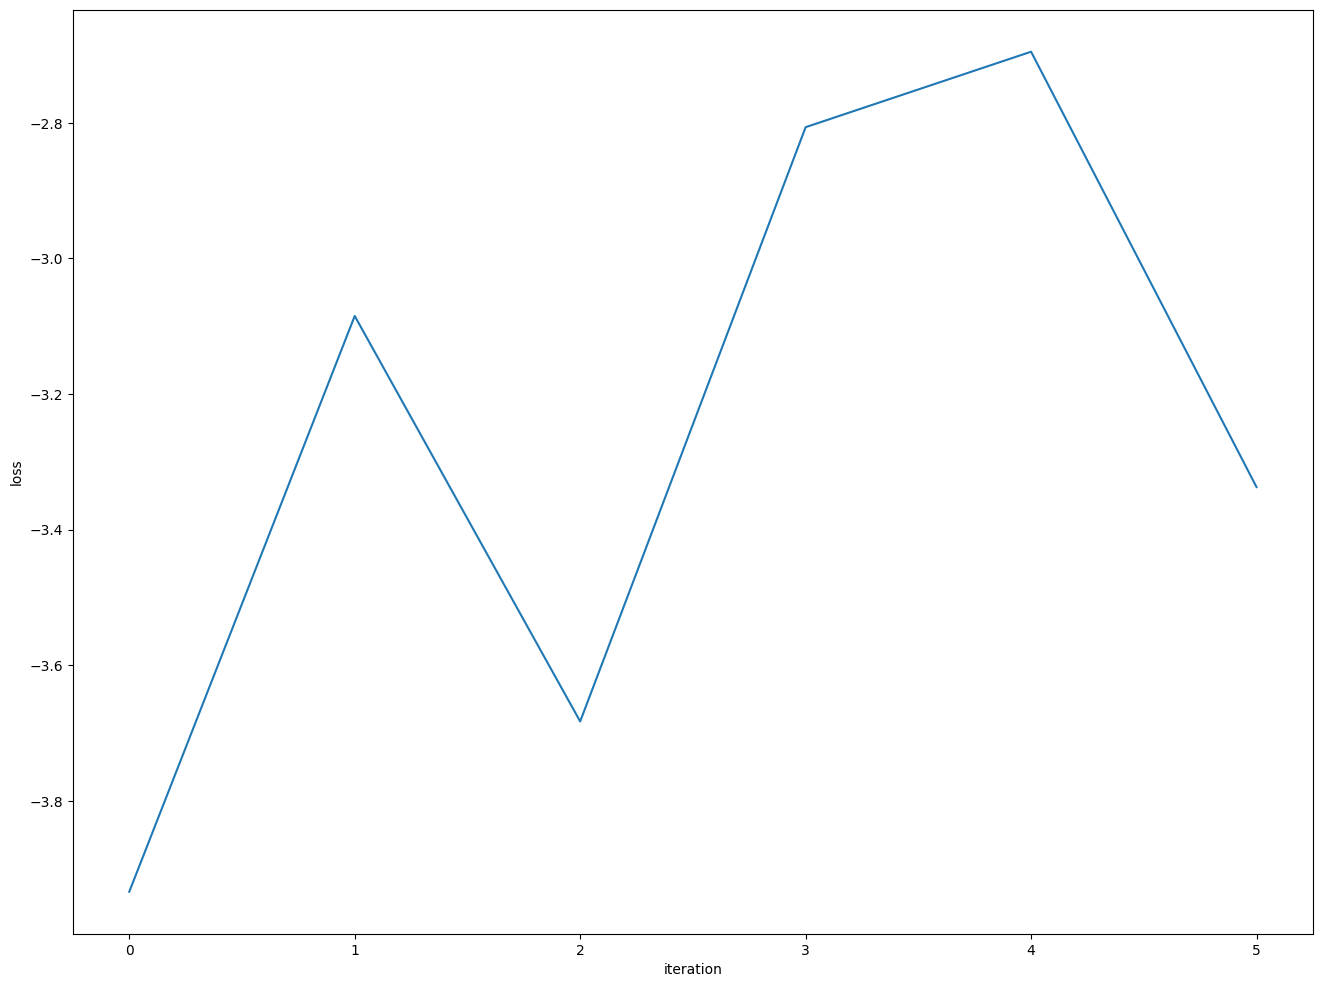

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

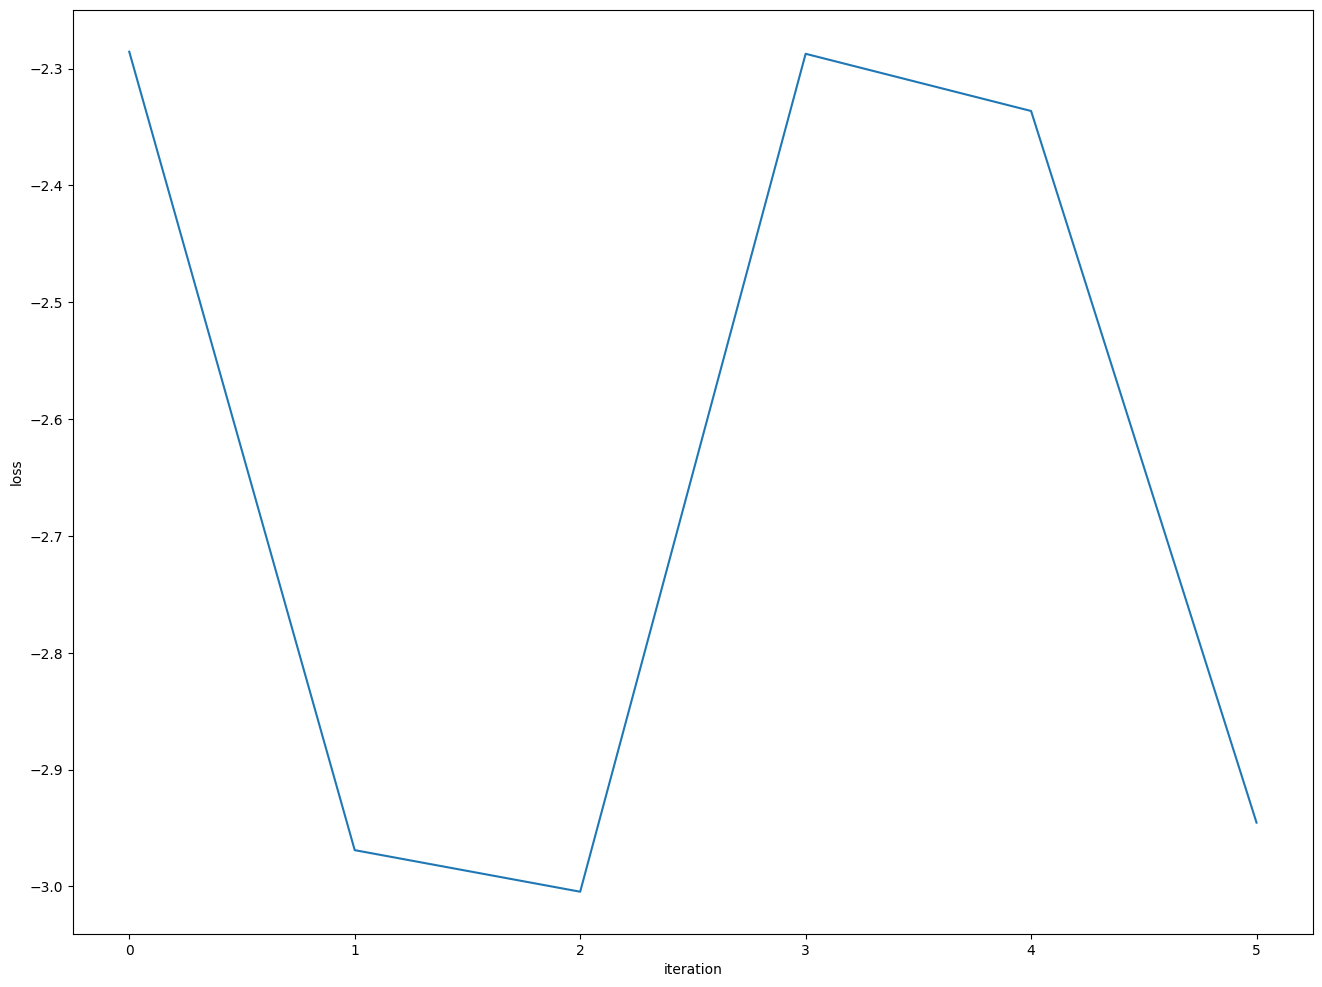

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")